# Preprocesamiento de Datos - Coffee Quality Database

Este notebook implementa la limpieza y preparación de datos basado en los hallazgos del Análisis Exploratorio (Notebook 01).

## Objetivos:


**Decisiones basadas en EDA:**


**Autor:** Ricardo Contreras, Daniel Leon, Santiago Graciano  
**Fecha:** Octubre 2025


## 1. Carga de Datos

In [98]:
# Importaciones estándar
import sys
from pathlib import Path
import warnings
import json

# Análisis de datos
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Machine Learning (para imputación y clustering)
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# Configuración
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Agregar src al path para imports
project_root = Path.cwd().parent
sys.path.append(str(project_root / 'src'))

print("✓ Librerías importadas correctamente")
print(f"✓ Pandas version: {pd.__version__}")
print(f"✓ NumPy version: {np.__version__}")
print(f"✓ Scikit-learn importado correctamente")


✓ Librerías importadas correctamente
✓ Pandas version: 2.3.3
✓ NumPy version: 2.3.4
✓ Scikit-learn importado correctamente


In [99]:
# Rutas a los datos
data_path = project_root / 'data' / 'raw'
reports_path = project_root / 'reports'

print(f"✓ Ruta de datos establecida en: {data_path}")

# Cargar dataset principal (merged)
merged_df = pd.read_csv(data_path / 'merged_data_cleaned.csv', index_col=0)

print(f"\n📊 Dataset Original:")
print(f"  - Dimensiones: {merged_df.shape}")
print(f"  - Muestras: {merged_df.shape[0]:,}")
print(f"  - Variables: {merged_df.shape[1]}")

# Cargar hallazgos del EDA
eda_findings_path = reports_path / 'eda_findings.json'
with open(eda_findings_path, 'r') as f:
    eda_findings = json.load(f)

print(f"\n✓ Hallazgos del EDA cargados:")
print(f"  - Variables a eliminar (>70% missing): {len(eda_findings['vars_to_drop'])}")
print(f"  - Variables a analizar (20-70% missing): {len(eda_findings['vars_to_analyze'])}")
print(f"  - Variables a imputar (<20% missing): {len(eda_findings['vars_to_impute'])}")

# Crear copia para trabajo
df = merged_df.copy()
print(f"\n✓ Copia de trabajo creada")


✓ Ruta de datos establecida en: /home/rickcontreras/proyectos/coffee-quality-prediction/data/raw

📊 Dataset Original:
  - Dimensiones: (1339, 43)
  - Muestras: 1,339
  - Variables: 43

✓ Hallazgos del EDA cargados:
  - Variables a eliminar (>70% missing): 1
  - Variables a analizar (20-70% missing): 3
  - Variables a imputar (<20% missing): 15

✓ Copia de trabajo creada

📊 Dataset Original:
  - Dimensiones: (1339, 43)
  - Muestras: 1,339
  - Variables: 43

✓ Hallazgos del EDA cargados:
  - Variables a eliminar (>70% missing): 1
  - Variables a analizar (20-70% missing): 3
  - Variables a imputar (<20% missing): 15

✓ Copia de trabajo creada


## 2. Limpieza de Datos

Aplicaremos la estrategia definida en el EDA:
1. **Eliminar muestras** con >20% de valores faltantes (Pareto)
2. **Eliminar variables** con >70% de valores faltantes



### 2.1 Eliminación de Muestras con Baja Calidad de Información

**Principio de Pareto (80/20):** Eliminaremos muestras con >20% de datos faltantes, ya que proporcionan poca información y pueden introducir ruido en los modelos.


Analizando el numero de muestras con valores nulos se decidio seguir el principio de Paretto, donde eliminamos todas las muestras que tuvieran mas del 20% de las columnas faltantes.

In [100]:
print("="*80)
print("ANÁLISIS DE MUESTRAS CON MUCHOS VALORES FALTANTES")
print("="*80)

# Estado inicial
print(f"\n📊 Estado Inicial:")
print(f"  - Total de muestras: {len(df):,}")
print(f"  - Total de variables: {df.shape[1]}")

# Verificar estado actual
print(f"\nEstado del dataset antes de eliminación:")
print(f"  - Forma: {df.shape}")


ANÁLISIS DE MUESTRAS CON MUCHOS VALORES FALTANTES

📊 Estado Inicial:
  - Total de muestras: 1,339
  - Total de variables: 43

Estado del dataset antes de eliminación:
  - Forma: (1339, 43)


In [101]:
# Calcular el porcentaje de valores faltantes por muestra (fila)
missing_per_sample = df.isnull().sum(axis=1)
missing_pct_per_sample = (missing_per_sample / df.shape[1]) * 100

# Crear un DataFrame con la información de muestras y sus datos faltantes
samples_missing_info = pd.DataFrame({
    'Missing_Count': missing_per_sample,
    'Missing_Percentage': missing_pct_per_sample
})

# Ordenar por cantidad de valores faltantes (descendente)
samples_missing_info = samples_missing_info.sort_values('Missing_Count', ascending=False)

# Estadísticas de missing por muestra
print(f"\n📈 Estadísticas de Datos Faltantes por Muestra:")
print(samples_missing_info['Missing_Percentage'].describe())

# Definir umbral según Principio de Pareto
threshold = 20
samples_high_missing = samples_missing_info[samples_missing_info['Missing_Percentage'] > threshold]

print(f"\n⚠️  Muestras con >{threshold}% de datos faltantes:")
print(f"  - Cantidad: {len(samples_high_missing)} ({len(samples_high_missing)/len(df)*100:.2f}% del total)")
print(f"  - Estos serán eliminados según Principio de Pareto")

# Mostrar distribución por rangos
print(f"\n📊 Distribución de muestras por % de datos faltantes:")
bins = [0, 10, 20, 30, 40, 50, 100]
labels = ['0-10%', '10-20%', '20-30%', '30-40%', '40-50%', '>50%']
samples_missing_info['Range'] = pd.cut(samples_missing_info['Missing_Percentage'], 
                                        bins=bins, labels=labels)
print(samples_missing_info['Range'].value_counts().sort_index())

display(samples_high_missing.head(10))


📈 Estadísticas de Datos Faltantes por Muestra:
count    1339.000000
mean        7.023638
std         7.263561
min         0.000000
25%         2.325581
50%         4.651163
75%         9.302326
max        34.883721
Name: Missing_Percentage, dtype: float64

⚠️  Muestras con >20% de datos faltantes:
  - Cantidad: 105 (7.84% del total)
  - Estos serán eliminados según Principio de Pareto

📊 Distribución de muestras por % de datos faltantes:
Range
0-10%     914
10-20%    188
20-30%     74
30-40%     31
40-50%      0
>50%        0
Name: count, dtype: int64
count    1339.000000
mean        7.023638
std         7.263561
min         0.000000
25%         2.325581
50%         4.651163
75%         9.302326
max        34.883721
Name: Missing_Percentage, dtype: float64

⚠️  Muestras con >20% de datos faltantes:
  - Cantidad: 105 (7.84% del total)
  - Estos serán eliminados según Principio de Pareto

📊 Distribución de muestras por % de datos faltantes:
Range
0-10%     914
10-20%    188
20-30%     7

,Missing_Count,Missing_Percentage
1197,15,34.883721
1138,14,32.558140
373,14,32.558140
1067,14,32.558140
414,14,32.558140
334,14,32.558140
1113,14,32.558140
495,14,32.558140
985,14,32.558140
629,14,32.558140


In [102]:
# Eliminar muestras con >20% missing
print("="*80)
print("ELIMINACIÓN DE MUESTRAS DE BAJA CALIDAD")
print("="*80)

print(f"\n📊 Antes de eliminar:")
print(f"  - Muestras: {len(df):,}")
print(f"  - Variables: {df.shape[1]}")

# Eliminar muestras
df = df.drop(index=samples_high_missing.index)

print(f"\n📊 Después de eliminar:")
print(f"  - Muestras: {len(df):,}")
print(f"  - Variables: {df.shape[1]}")
print(f"  - Muestras eliminadas: {len(samples_high_missing):,}")
print(f"  - Reducción: {len(samples_high_missing)/len(merged_df)*100:.2f}%")

print(f"\n✅ Eliminación completada")

ELIMINACIÓN DE MUESTRAS DE BAJA CALIDAD

📊 Antes de eliminar:
  - Muestras: 1,339
  - Variables: 43

📊 Después de eliminar:
  - Muestras: 1,234
  - Variables: 43
  - Muestras eliminadas: 105
  - Reducción: 7.84%

✅ Eliminación completada


# Analisis

ANÁLISIS DETALLADO DE VARIABLES CATEGÓRICAS

📊 Total de variables categóricas: 24


📋 VARIABLE: Species

📊 Estadísticas:
   • Total de valores: 1,234
   • Valores no nulos: 1,234 (100.0%)
   • Valores nulos: 0 (0.0%)
   • Valores únicos: 2

📊 Distribución de valores:

   Todos los valores (2):
    1. Arabica: 1,208 (97.89%)
    2. Robusta: 26 (2.11%)


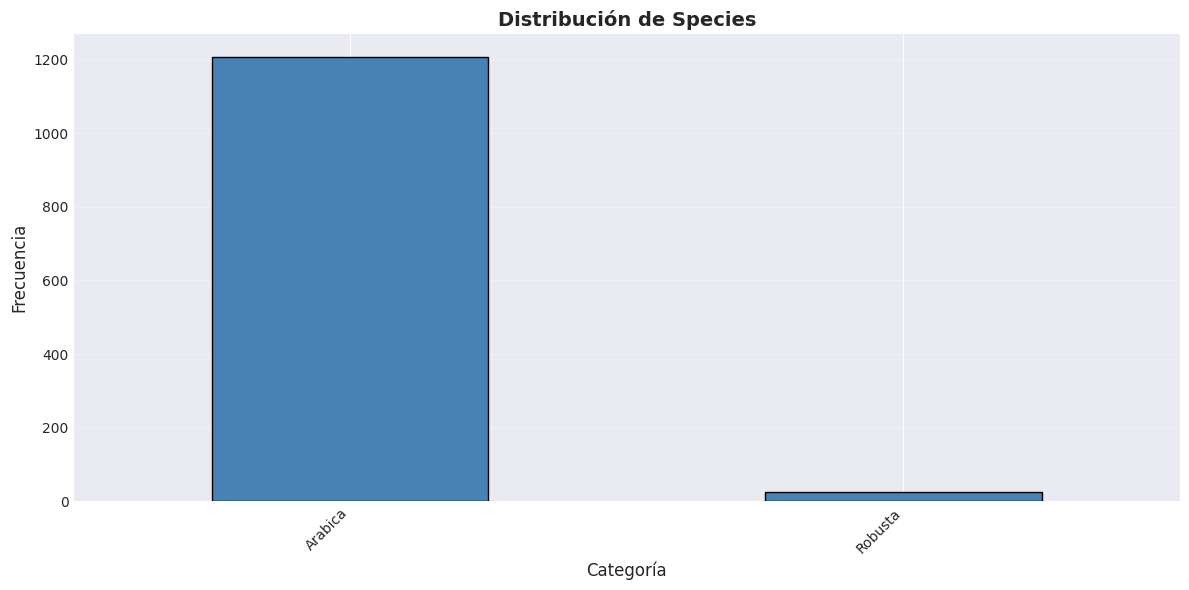




📋 VARIABLE: Owner

📊 Estadísticas:
   • Total de valores: 1,234
   • Valores no nulos: 1,227 (99.4%)
   • Valores nulos: 7 (0.6%)
   • Valores únicos: 299

📊 Distribución de valores:

   Top 15 valores más frecuentes:
    1. juan luis alvarado romero: 155 (12.63%)
    2. exportadora de cafe condor s.a: 53 (4.32%)
    3. racafe & cia s.c.a: 53 (4.32%)
    4. ipanema coffees: 50 (4.07%)
    5. cqi taiwan icp cqi台灣合作夥伴: 47 (3.83%)
    6. lin, che-hao krude 林哲豪: 30 (2.44%)
    7. nucoffee: 29 (2.36%)
    8. carcafe ltda ci: 27 (2.20%)
    9. the coffee source inc.: 23 (1.87%)
   10. kona pacific farmers cooperative: 22 (1.79%)
   11. eileen koyanagi: 19 (1.55%)
   12. alfredo bojalil: 19 (1.55%)
   13. afca: 17 (1.39%)
   14. bourbon specialty coffees: 17 (1.39%)
   15. bismarck castro: 15 (1.22%)

   💡 Los top 15 valores cubren: 46.9% de los datos
   💡 Valores restantes: 284


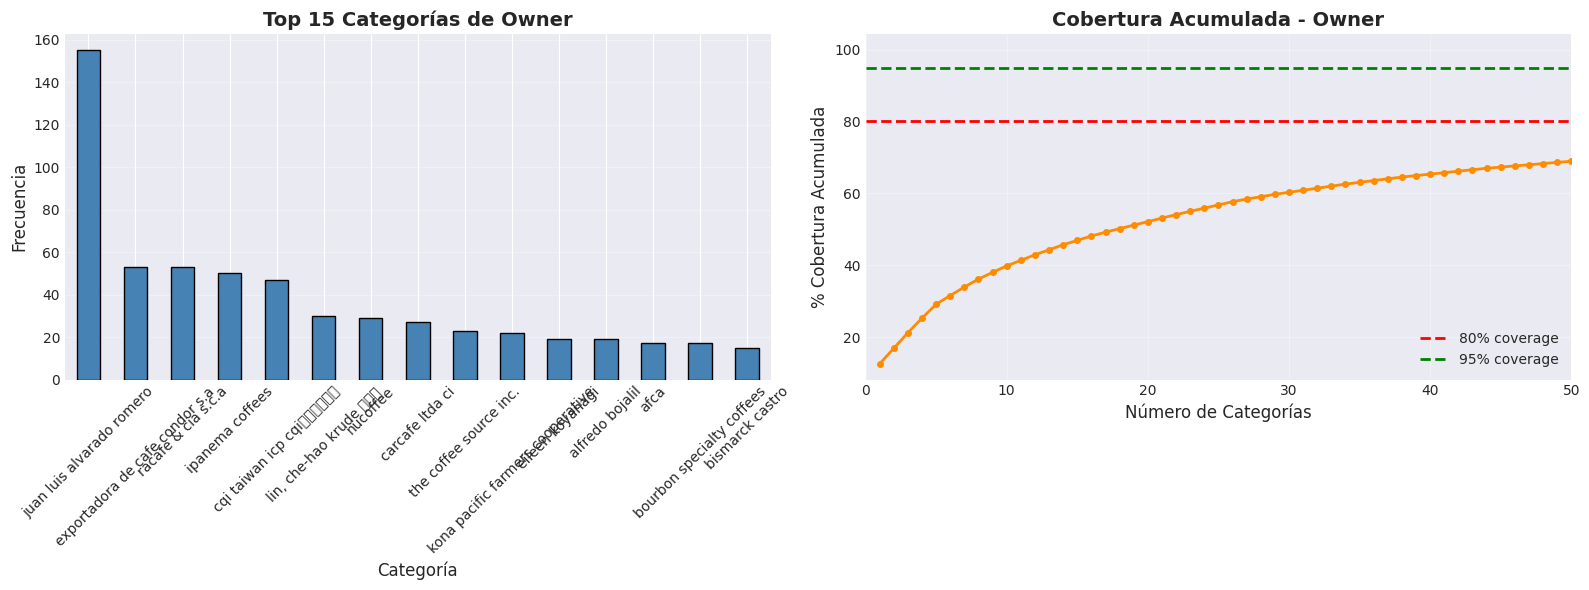




📋 VARIABLE: Country.of.Origin

📊 Estadísticas:
   • Total de valores: 1,234
   • Valores no nulos: 1,234 (100.0%)
   • Valores nulos: 0 (0.0%)
   • Valores únicos: 36

📊 Distribución de valores:

   Top 15 valores más frecuentes:
    1. Mexico: 236 (19.12%)
    2. Guatemala: 175 (14.18%)
    3. Colombia: 165 (13.37%)
    4. Brazil: 127 (10.29%)
    5. Taiwan: 75 (6.08%)
    6. Honduras: 51 (4.13%)
    7. Costa Rica: 46 (3.73%)
    8. United States (Hawaii): 43 (3.48%)
    9. Tanzania, United Republic Of: 39 (3.16%)
   10. Uganda: 36 (2.92%)
   11. Ethiopia: 32 (2.59%)
   12. Thailand: 23 (1.86%)
   13. Kenya: 23 (1.86%)
   14. Nicaragua: 22 (1.78%)
   15. Indonesia: 20 (1.62%)

   💡 Los top 15 valores cubren: 90.2% de los datos
   💡 Valores restantes: 21


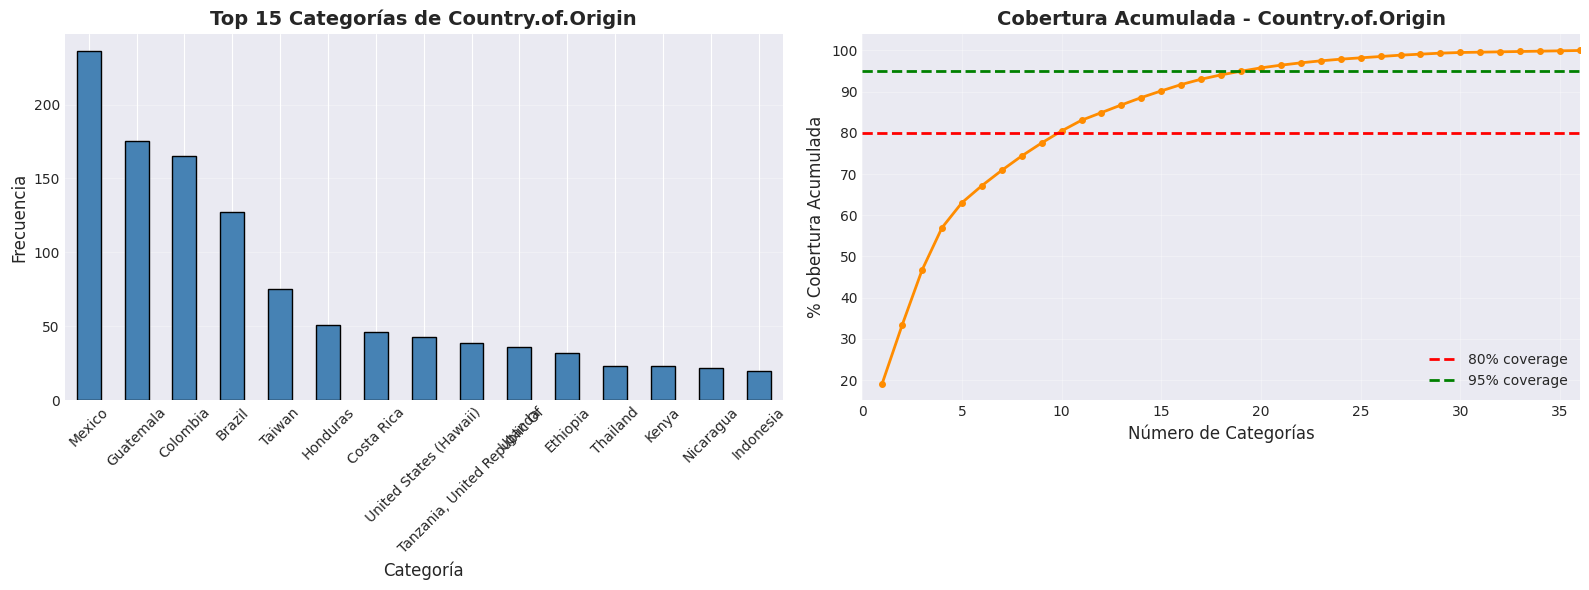




📋 VARIABLE: Farm.Name

📊 Estadísticas:
   • Total de valores: 1,234
   • Valores no nulos: 958 (77.6%)
   • Valores nulos: 276 (22.4%)
   • Valores únicos: 566

📊 Distribución de valores:

   Top 15 valores más frecuentes:
    1. various: 47 (4.91%)
    2. rio verde: 23 (2.40%)
    3. several: 20 (2.09%)
    4. finca medina: 15 (1.57%)
    5. fazenda capoeirnha: 13 (1.36%)
    6. conquista / morito: 11 (1.15%)
    7. los hicaques: 11 (1.15%)
    8. capoeirinha: 10 (1.04%)
    9. el papaturro: 9 (0.94%)
   10. agropecuaria quiagral: 8 (0.84%)
   11. el morito: 8 (0.84%)
   12. cerro bueno: 8 (0.84%)
   13. la esmeralda: 7 (0.73%)
   14. gamboa: 7 (0.73%)
   15. bethel: 7 (0.73%)

   💡 Los top 15 valores cubren: 21.3% de los datos
   💡 Valores restantes: 551


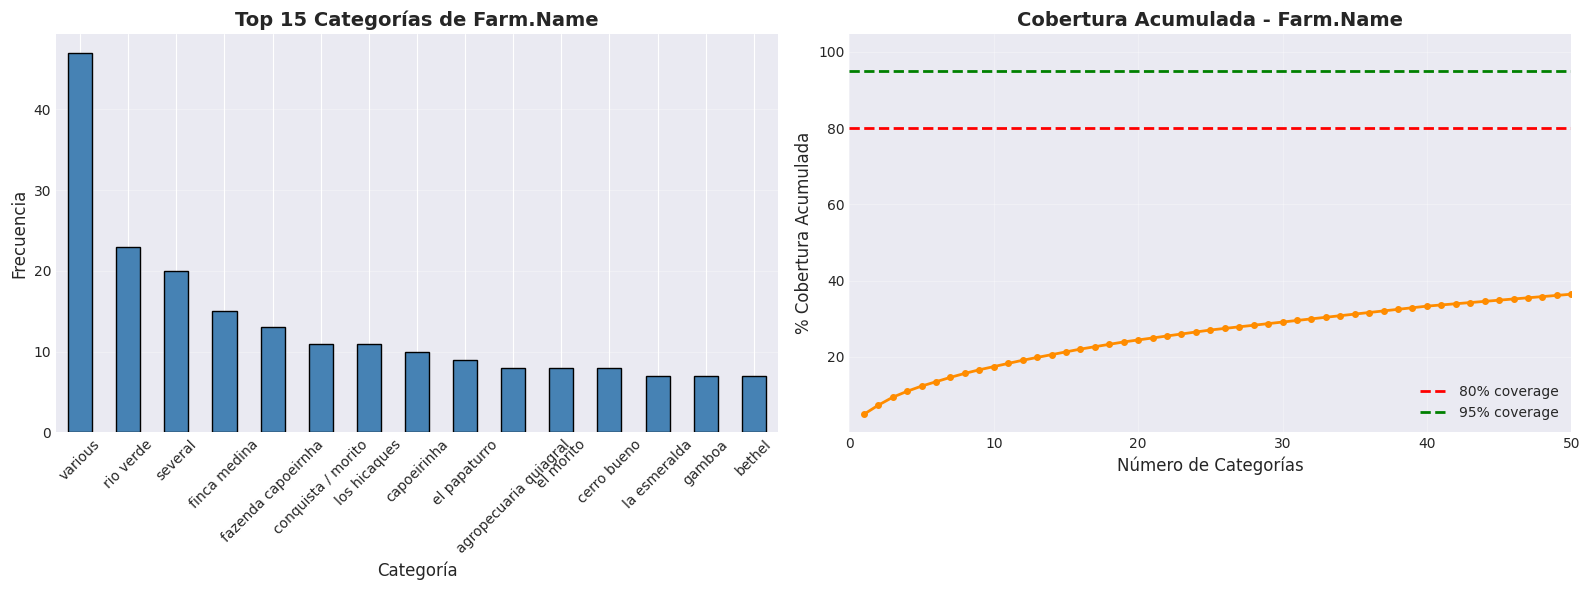




📋 VARIABLE: Lot.Number

📊 Estadísticas:
   • Total de valores: 1,234
   • Valores no nulos: 271 (22.0%)
   • Valores nulos: 963 (78.0%)
   • Valores únicos: 223

📊 Distribución de valores:

   Top 15 valores más frecuentes:
    1. 1: 17 (6.27%)
    2. 020/17: 6 (2.21%)
    3. 019/17: 5 (1.85%)
    4. 2: 3 (1.11%)
    5. 103: 3 (1.11%)
    6. 2016 Tainan Coffee Cupping Event Micro Lot 臺南市咖啡評鑑批次: 3 (1.11%)
    7. 102: 3 (1.11%)
    8. 43102245 - P4615: 2 (0.74%)
    9. 11/52/1170: 2 (0.74%)
   10. 2017南投咖啡評鑑 NANTOU COFFEE EVALUATION EVENT 2017: 2 (0.74%)
   11. SC 9634: 2 (0.74%)
   12. Tarrazu: 2 (0.74%)
   13. 11/23/0632: 2 (0.74%)
   14. 11/23/0693: 2 (0.74%)
   15. 1-198: 2 (0.74%)

   💡 Los top 15 valores cubren: 20.7% de los datos
   💡 Valores restantes: 208


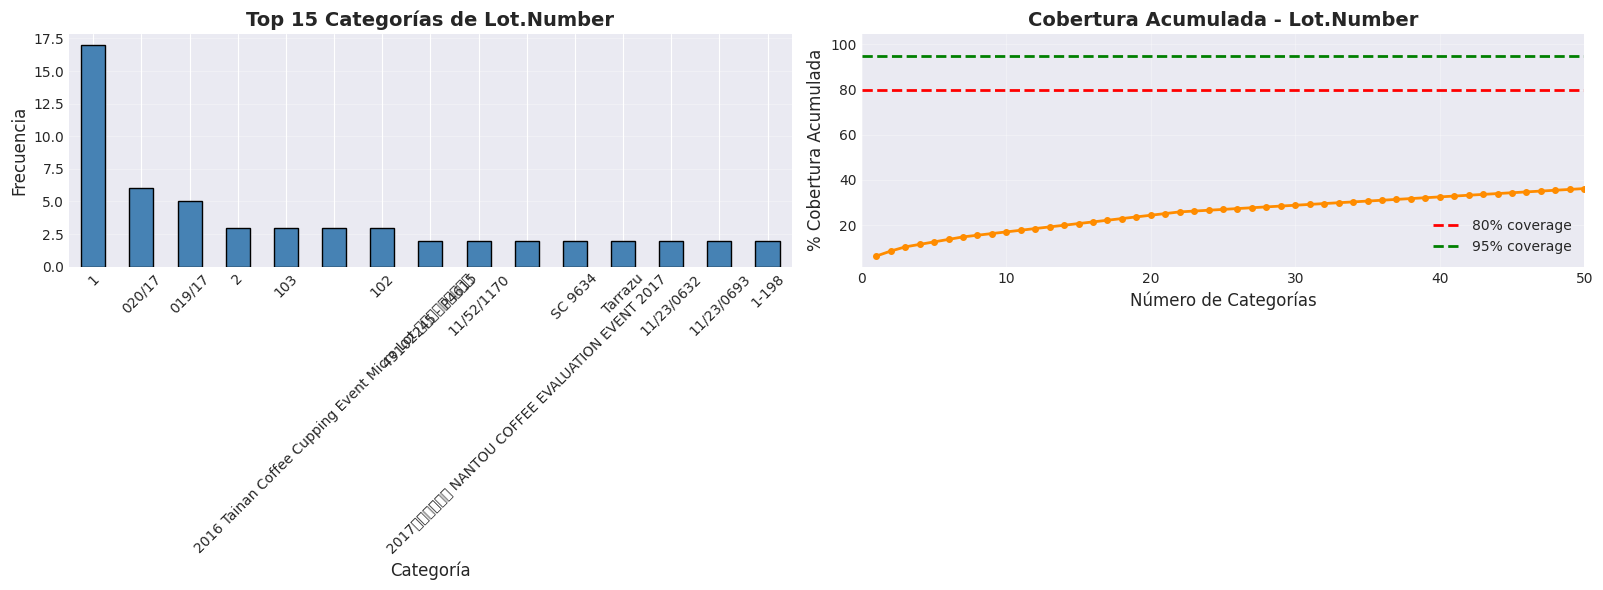




📋 VARIABLE: Mill

📊 Estadísticas:
   • Total de valores: 1,234
   • Valores no nulos: 1,010 (81.8%)
   • Valores nulos: 224 (18.2%)
   • Valores únicos: 455

📊 Distribución de valores:

   Top 15 valores más frecuentes:
    1. beneficio ixchel: 90 (8.91%)
    2. dry mill: 39 (3.86%)
    3. trilladora boananza: 37 (3.66%)
    4. ipanema coffees: 16 (1.58%)
    5. neiva: 15 (1.49%)
    6. bachue: 13 (1.29%)
    7. cigrah s.a de c.v.: 12 (1.19%)
    8. cadexsa: 12 (1.19%)
    9. beneficio siembras vision (154): 12 (1.19%)
   10. trilladora bonanza - armenia quindioa: 12 (1.19%)
   11. beneficio exportacafe agua santa: 11 (1.09%)
   12. zaragoza itundujia, oaxaca: 11 (1.09%)
   13. ipanema comercial e exportadora sa: 11 (1.09%)
   14. mzuzu coffee coop union: 9 (0.89%)
   15. agroindustrias unidas de mexico: 9 (0.89%)

   💡 Los top 15 valores cubren: 30.6% de los datos
   💡 Valores restantes: 440


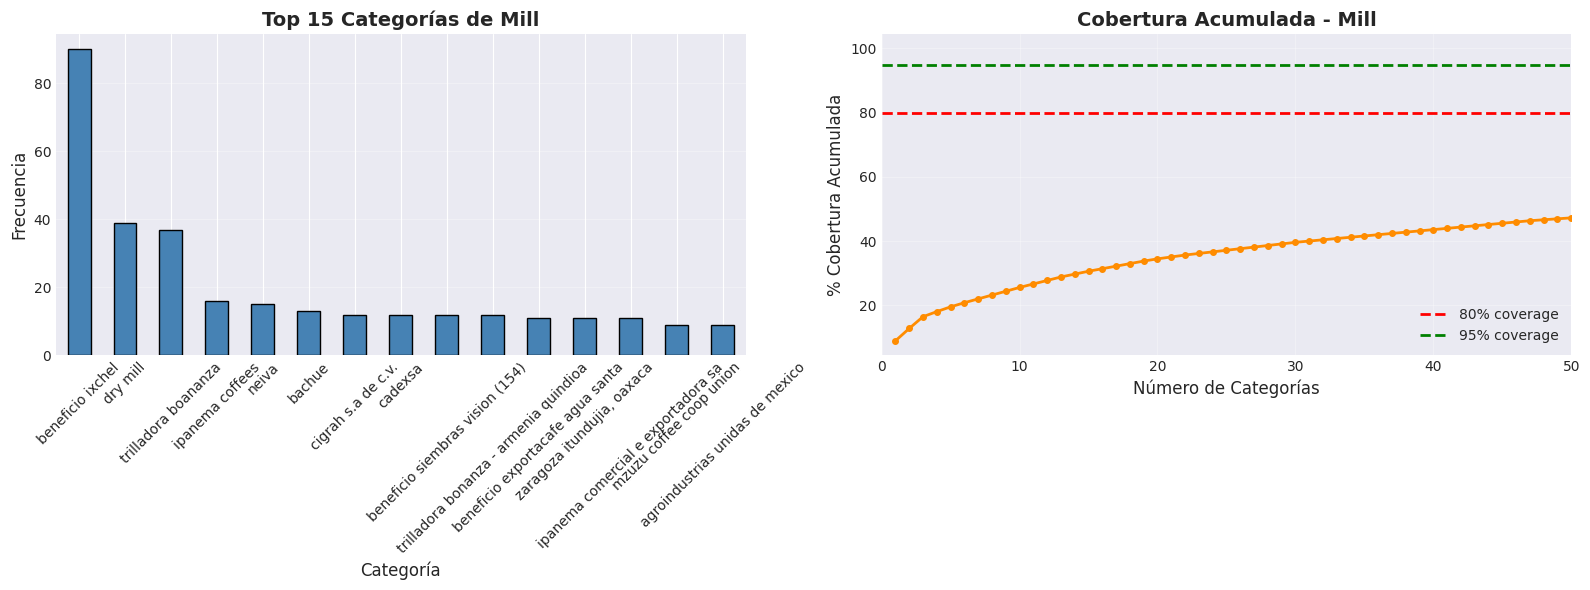




📋 VARIABLE: ICO.Number

📊 Estadísticas:
   • Total de valores: 1,234
   • Valores no nulos: 1,102 (89.3%)
   • Valores nulos: 132 (10.7%)
   • Valores únicos: 781

📊 Distribución de valores:

   Top 15 valores más frecuentes:
    1. 0: 77 (6.99%)
    2. Taiwan: 31 (2.81%)
    3. 2222: 11 (1.00%)
    4. -: 9 (0.82%)
    5. 002/1660/0105: 7 (0.64%)
    6. Taiwan台灣: 7 (0.64%)
    7. 002/4177/0150: 7 (0.64%)
    8. unknown: 6 (0.54%)
    9. 002/1660/0080: 6 (0.54%)
   10. 2014/2015: 5 (0.45%)
   11. 11-951-136: 5 (0.45%)
   12. 002/1660/0079: 5 (0.45%)
   13. NONE: 5 (0.45%)
   14. 1: 5 (0.45%)
   15. 2676: 5 (0.45%)

   💡 Los top 15 valores cubren: 17.3% de los datos
   💡 Valores restantes: 766


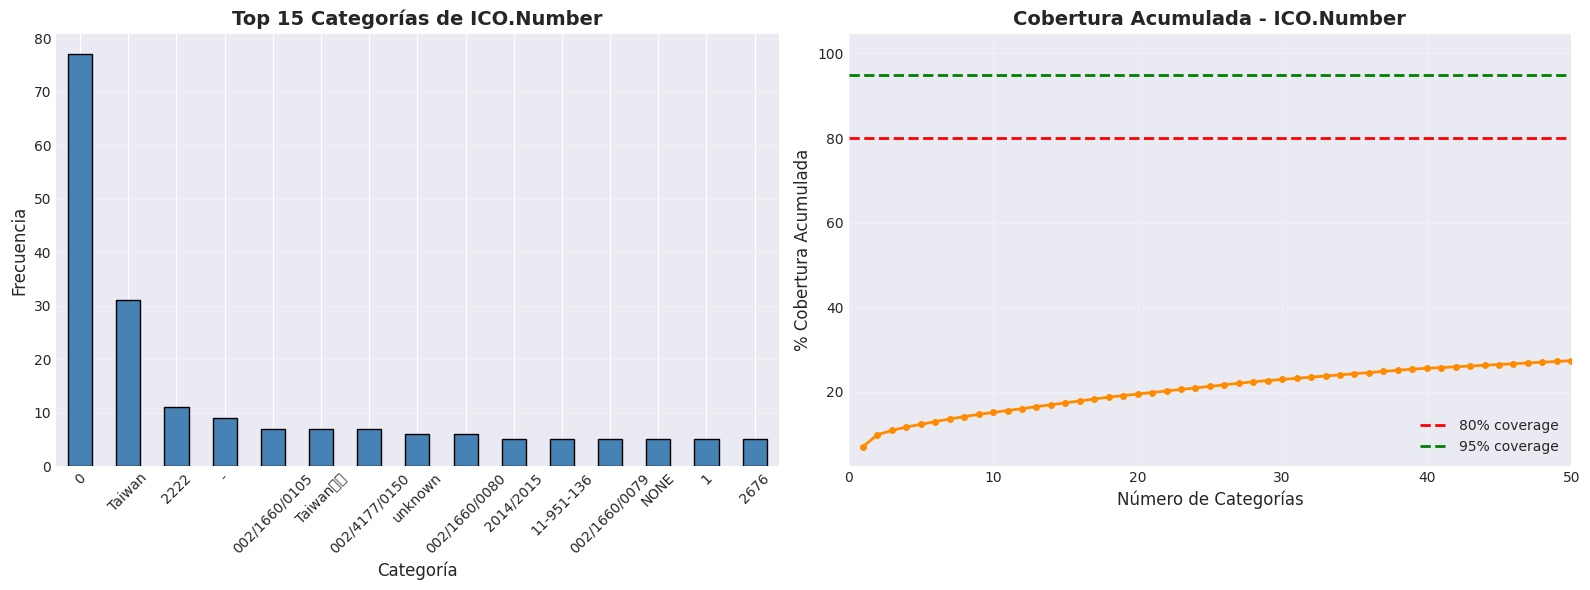




📋 VARIABLE: Company

📊 Estadísticas:
   • Total de valores: 1,234
   • Valores no nulos: 1,086 (88.0%)
   • Valores nulos: 148 (12.0%)
   • Valores únicos: 274

📊 Distribución de valores:

   Top 15 valores más frecuentes:
    1. unex guatemala, s.a.: 86 (7.92%)
    2. ipanema coffees: 50 (4.60%)
    3. exportadora de cafe condor s.a: 39 (3.59%)
    4. racafe & cia s.c.a: 37 (3.41%)
    5. kona pacific farmers cooperative: 33 (3.04%)
    6. blossom valley宸嶧國際: 25 (2.30%)
    7. carcafe ltda: 25 (2.30%)
    8. nucoffee: 24 (2.21%)
    9. taiwan coffee laboratory: 20 (1.84%)
   10. ecomtrading: 19 (1.75%)
   11. 宸嶧國際: 19 (1.75%)
   12. the coffee source inc.: 19 (1.75%)
   13. bourbon specialty coffees: 17 (1.57%)
   14. cadexsa: 15 (1.38%)
   15. cigrah s.a de c.v: 15 (1.38%)

   💡 Los top 15 valores cubren: 40.8% de los datos
   💡 Valores restantes: 259


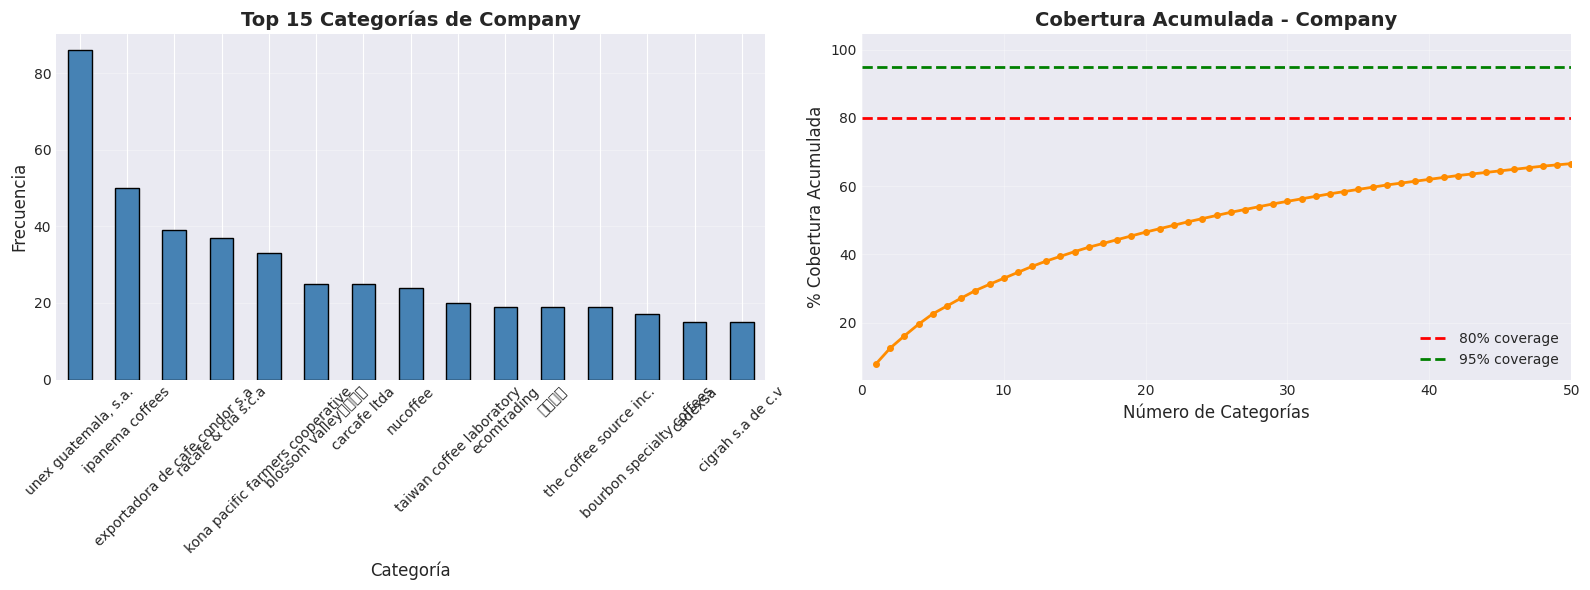




📋 VARIABLE: Altitude

📊 Estadísticas:
   • Total de valores: 1,234
   • Valores no nulos: 1,107 (89.7%)
   • Valores nulos: 127 (10.3%)
   • Valores únicos: 391

📊 Distribución de valores:

   Top 15 valores más frecuentes:
    1. 1100: 43 (3.88%)
    2. 1200: 42 (3.79%)
    3. 1400: 32 (2.89%)
    4. 1300: 32 (2.89%)
    5. 4300: 31 (2.80%)
    6. 1250: 30 (2.71%)
    7. 1500: 30 (2.71%)
    8. 1700: 28 (2.53%)
    9. 1550: 24 (2.17%)
   10. 1800: 22 (1.99%)
   11. 1600: 22 (1.99%)
   12. de 1600 a 1950 msnm: 21 (1.90%)
   13. 1750 msnm: 21 (1.90%)
   14. 1350: 20 (1.81%)
   15. 1450: 15 (1.36%)

   💡 Los top 15 valores cubren: 37.3% de los datos
   💡 Valores restantes: 376


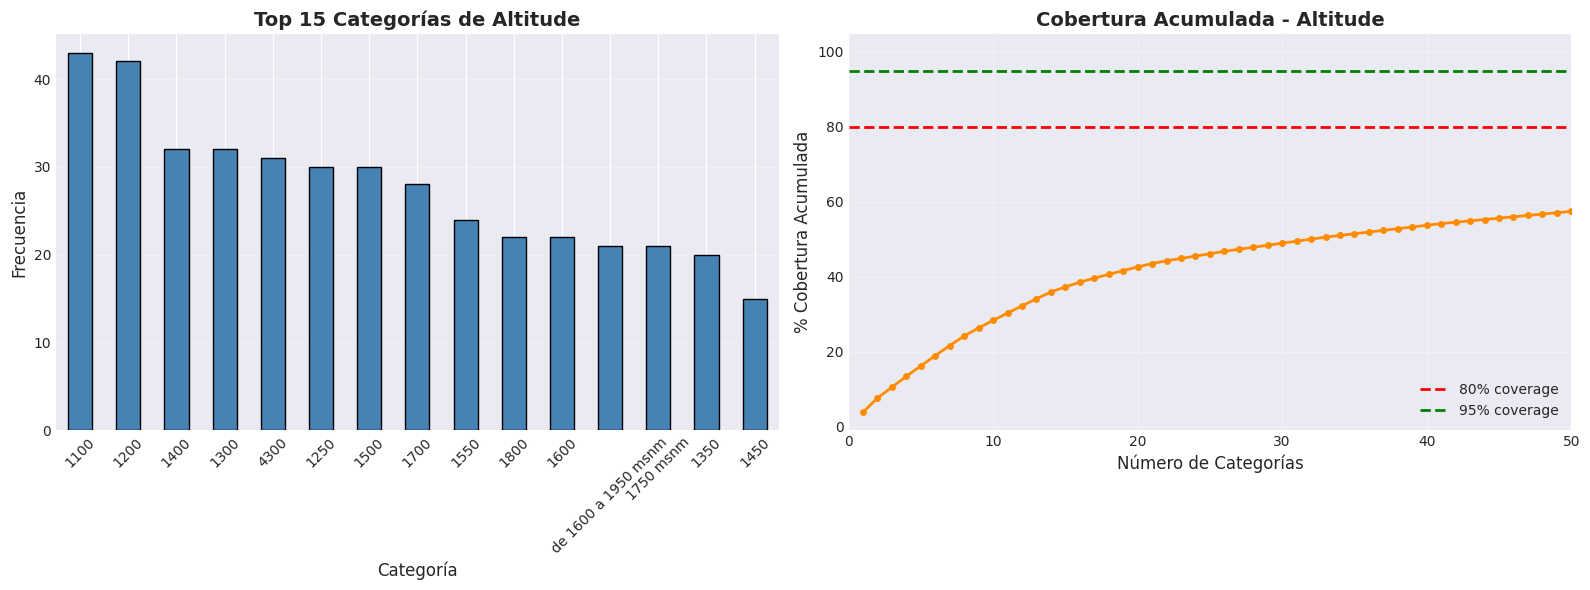




📋 VARIABLE: Region

📊 Estadísticas:
   • Total de valores: 1,234
   • Valores no nulos: 1,225 (99.3%)
   • Valores nulos: 9 (0.7%)
   • Valores únicos: 348

📊 Distribución de valores:

   Top 15 valores más frecuentes:
    1. huila: 106 (8.65%)
    2. oriente: 80 (6.53%)
    3. south of minas: 68 (5.55%)
    4. kona: 43 (3.51%)
    5. veracruz: 35 (2.86%)
    6. tarrazu: 18 (1.47%)
    7. comayagua: 17 (1.39%)
    8. san marcos: 16 (1.31%)
    9. antigua: 15 (1.22%)
   10. marcala: 15 (1.22%)
   11. huehuetenango: 15 (1.22%)
   12. coatepec: 14 (1.14%)
   13. thailand: 14 (1.14%)
   14. yunnan: 13 (1.06%)
   15. jinotega: 13 (1.06%)

   💡 Los top 15 valores cubren: 39.3% de los datos
   💡 Valores restantes: 333


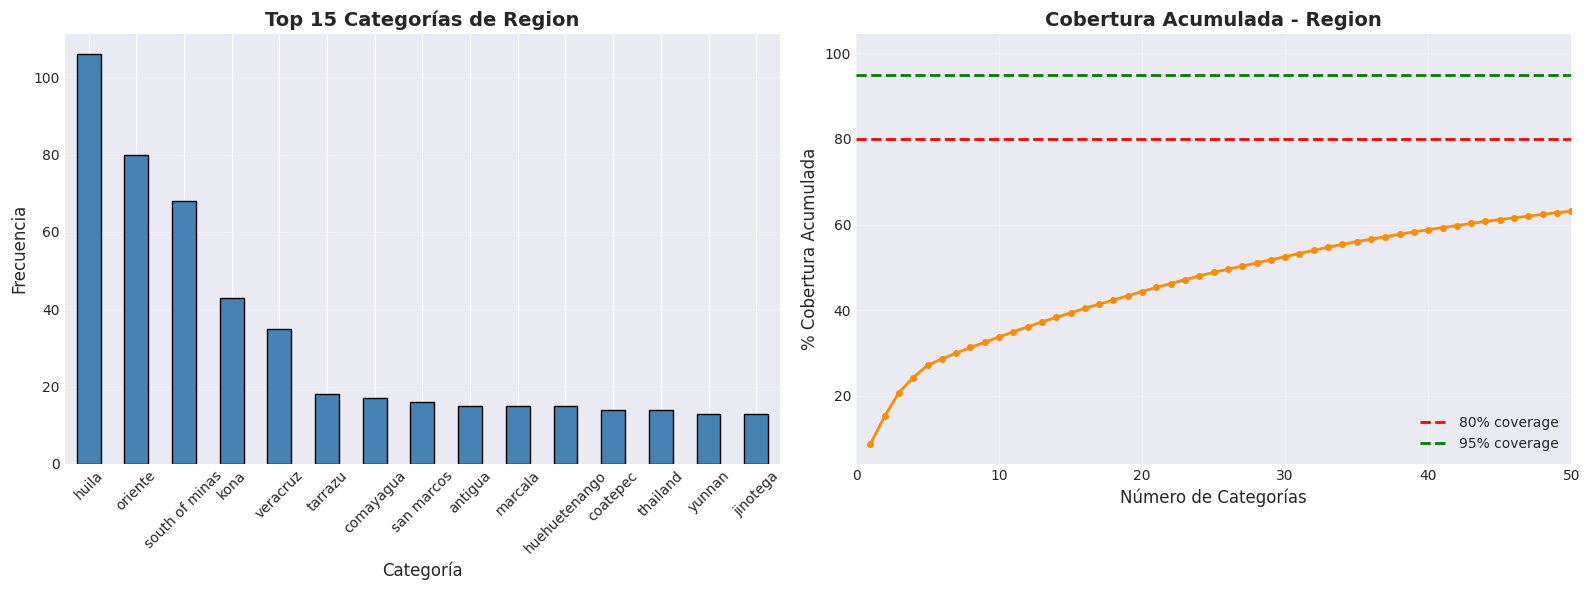




📋 VARIABLE: Producer

📊 Estadísticas:
   • Total de valores: 1,234
   • Valores no nulos: 1,083 (87.8%)
   • Valores nulos: 151 (12.2%)
   • Valores únicos: 680

📊 Distribución de valores:

   Top 15 valores más frecuentes:
    1. La Plata: 30 (2.77%)
    2. Ipanema Agrícola SA: 22 (2.03%)
    3. VARIOS: 12 (1.11%)
    4. Doi Tung Development Project: 12 (1.11%)
    5. Ipanema Agricola: 12 (1.11%)
    6. Ipanema Agricola S.A: 11 (1.02%)
    7. ROBERTO MONTERROSO: 10 (0.92%)
    8. LA PLATA: 9 (0.83%)
    9. AMILCAR LAPOLA: 9 (0.83%)
   10. Reinerio Zepeda: 9 (0.83%)
   11. AGROPECUARIA QUIAGRAL: 8 (0.74%)
   12. Martin Gutierrez: 8 (0.74%)
   13. JESUS RAMIREZ: 7 (0.65%)
   14. varios: 7 (0.65%)
   15. Mzuzu Coffee Coop Union: 6 (0.55%)

   💡 Los top 15 valores cubren: 15.9% de los datos
   💡 Valores restantes: 665


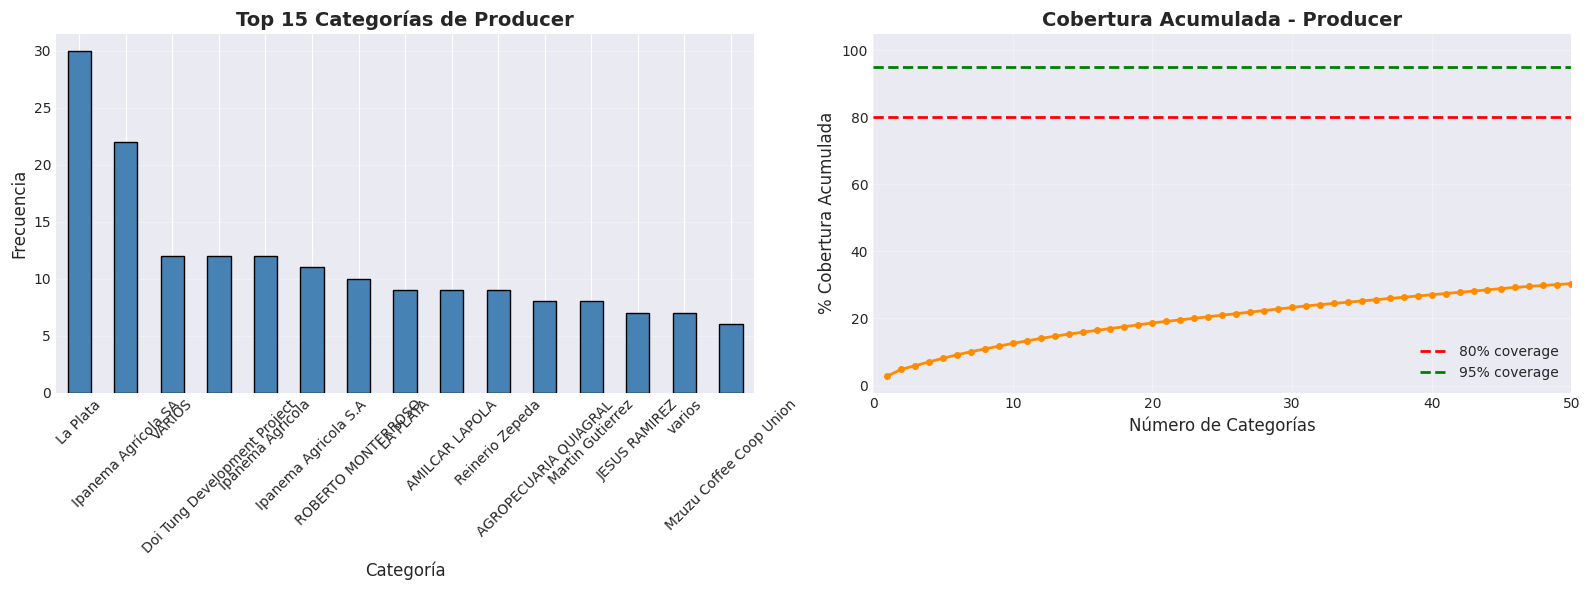




📋 VARIABLE: Bag.Weight

📊 Estadísticas:
   • Total de valores: 1,234
   • Valores no nulos: 1,234 (100.0%)
   • Valores nulos: 0 (0.0%)
   • Valores únicos: 50

📊 Distribución de valores:

   Top 15 valores más frecuentes:
    1. 1 kg: 328 (26.58%)
    2. 60 kg: 244 (19.77%)
    3. 69 kg: 199 (16.13%)
    4. 70 kg: 145 (11.75%)
    5. 2 kg: 109 (8.83%)
    6. 100 lbs: 36 (2.92%)
    7. 30 kg: 28 (2.27%)
    8. 50 kg: 14 (1.13%)
    9. 20 kg: 14 (1.13%)
   10. 10 kg: 11 (0.89%)
   11. 59 kg: 10 (0.81%)
   12. 5 lbs: 10 (0.81%)
   13. 6: 10 (0.81%)
   14. 5 kg: 7 (0.57%)
   15. 3 lbs: 7 (0.57%)

   💡 Los top 15 valores cubren: 95.0% de los datos
   💡 Valores restantes: 35


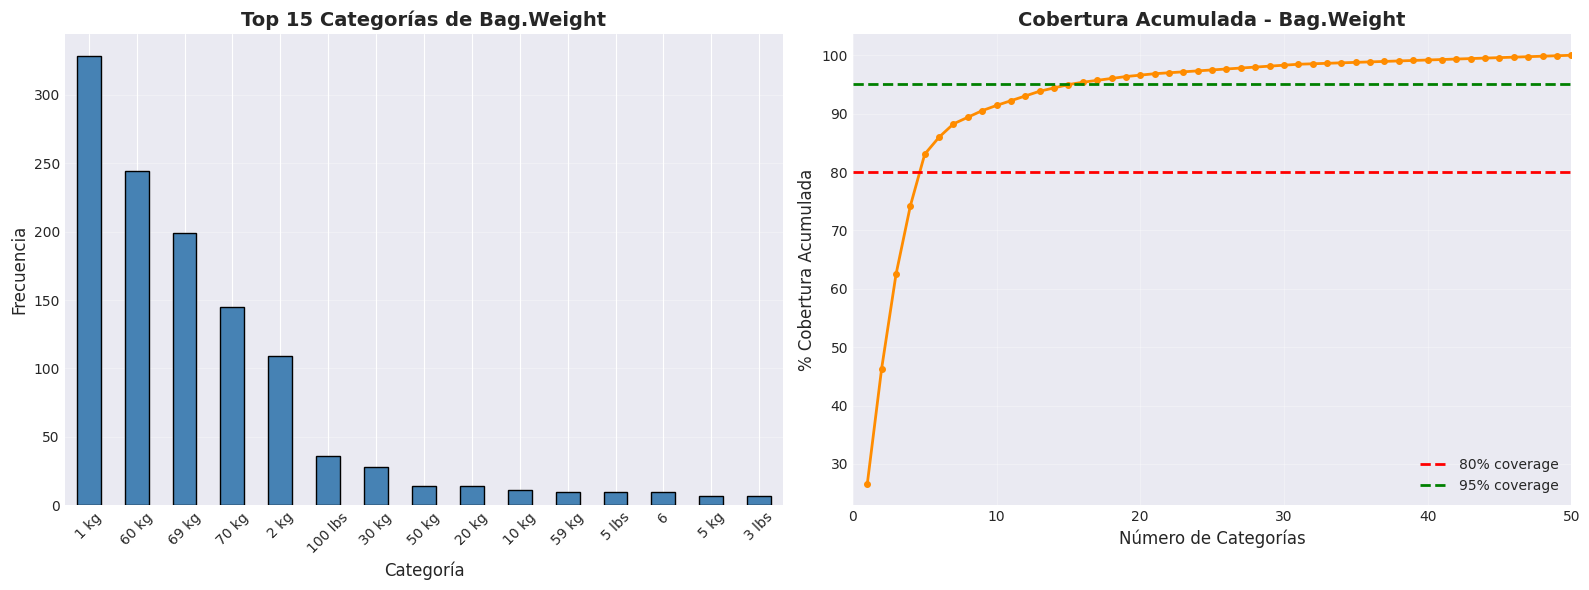




📋 VARIABLE: In.Country.Partner

📊 Estadísticas:
   • Total de valores: 1,234
   • Valores no nulos: 1,234 (100.0%)
   • Valores nulos: 0 (0.0%)
   • Valores únicos: 26

📊 Distribución de valores:

   Top 15 valores más frecuentes:
    1. Specialty Coffee Association: 241 (19.53%)
    2. AMECAFE: 205 (16.61%)
    3. Almacafé: 163 (13.21%)
    4. Asociacion Nacional Del Café: 155 (12.56%)
    5. Brazil Specialty Coffee Association: 67 (5.43%)
    6. Instituto Hondureño del Café: 60 (4.86%)
    7. Blossom Valley International: 58 (4.70%)
    8. Africa Fine Coffee Association: 49 (3.97%)
    9. Specialty Coffee Association of Costa Rica: 42 (3.40%)
   10. NUCOFFEE: 34 (2.76%)
   11. Uganda Coffee Development Authority: 32 (2.59%)
   12. Kenya Coffee Traders Association: 21 (1.70%)
   13. METAD Agricultural Development plc: 15 (1.22%)
   14. Specialty Coffee Institute of Asia: 13 (1.05%)
   15. Yunnan Coffee Exchange: 12 (0.97%)

   💡 Los top 15 valores cubren: 94.6% de los datos
   💡 Va

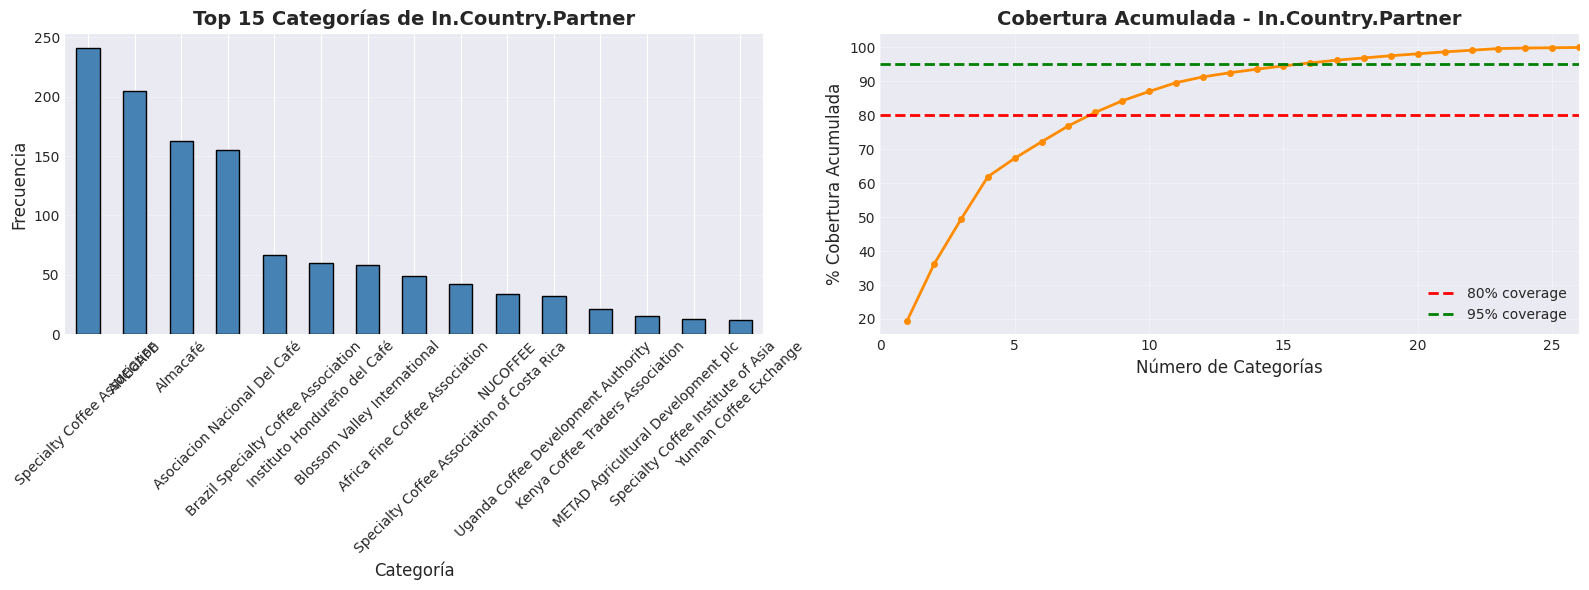




📋 VARIABLE: Harvest.Year

📊 Estadísticas:
   • Total de valores: 1,234
   • Valores no nulos: 1,224 (99.2%)
   • Valores nulos: 10 (0.8%)
   • Valores únicos: 44

📊 Distribución de valores:

   Top 15 valores más frecuentes:
    1. 2012: 335 (27.37%)
    2. 2014: 229 (18.71%)
    3. 2013: 165 (13.48%)
    4. 2015: 126 (10.29%)
    5. 2016: 121 (9.89%)
    6. 2017: 68 (5.56%)
    7. 2013/2014: 29 (2.37%)
    8. 2015/2016: 28 (2.29%)
    9. 2011: 22 (1.80%)
   10. 2017 / 2018: 19 (1.55%)
   11. 2014/2015: 19 (1.55%)
   12. 2009/2010: 6 (0.49%)
   13. 2016 / 2017: 6 (0.49%)
   14. 2010-2011: 5 (0.41%)
   15. 4T/10: 4 (0.33%)

   💡 Los top 15 valores cubren: 96.6% de los datos
   💡 Valores restantes: 29


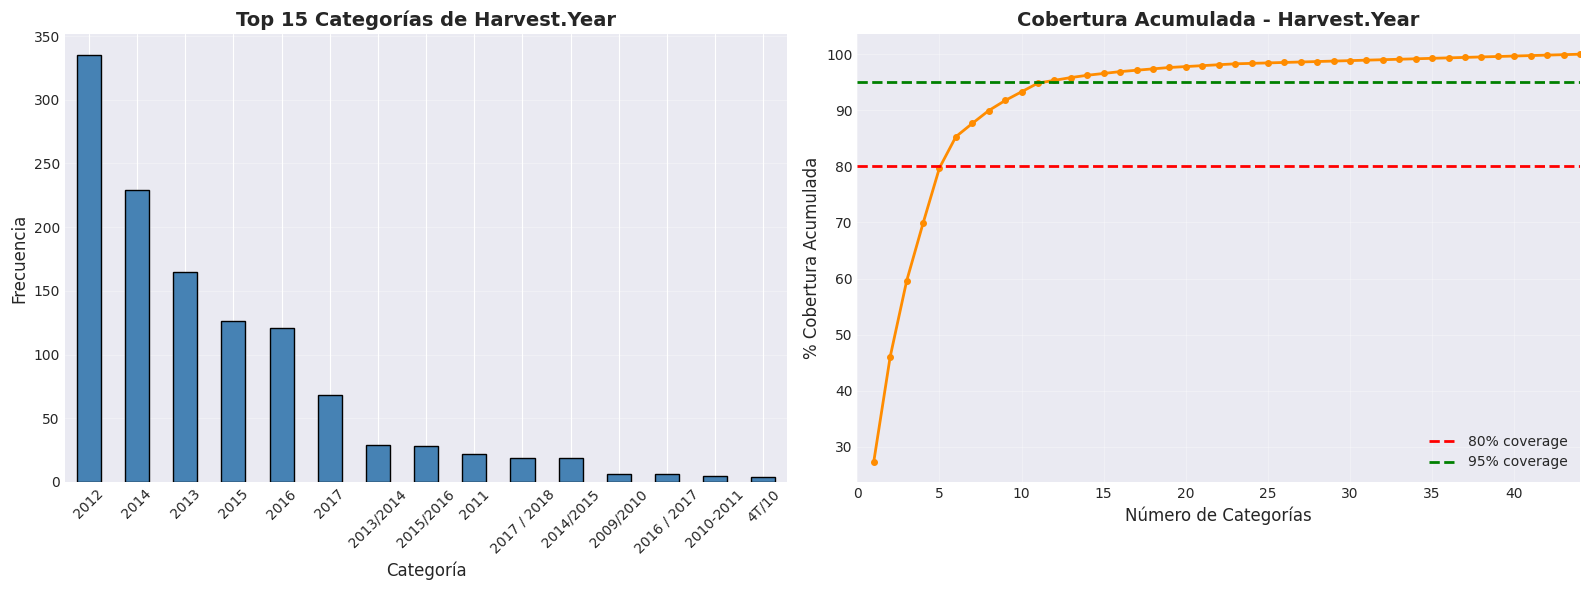




📋 VARIABLE: Grading.Date

📊 Estadísticas:
   • Total de valores: 1,234
   • Valores no nulos: 1,234 (100.0%)
   • Valores nulos: 0 (0.0%)
   • Valores únicos: 531

📊 Distribución de valores:

   Top 15 valores más frecuentes:
    1. July 11th, 2012: 25 (2.03%)
    2. December 26th, 2013: 24 (1.94%)
    3. June 6th, 2012: 19 (1.54%)
    4. August 30th, 2012: 18 (1.46%)
    5. July 26th, 2012: 15 (1.22%)
    6. March 29th, 2013: 13 (1.05%)
    7. October 8th, 2015: 13 (1.05%)
    8. September 27th, 2012: 13 (1.05%)
    9. September 17th, 2012: 11 (0.89%)
   10. October 20th, 2017: 11 (0.89%)
   11. December 12th, 2014: 10 (0.81%)
   12. September 10th, 2012: 10 (0.81%)
   13. December 18th, 2014: 10 (0.81%)
   14. September 11th, 2012: 9 (0.73%)
   15. April 6th, 2016: 9 (0.73%)

   💡 Los top 15 valores cubren: 17.0% de los datos
   💡 Valores restantes: 516


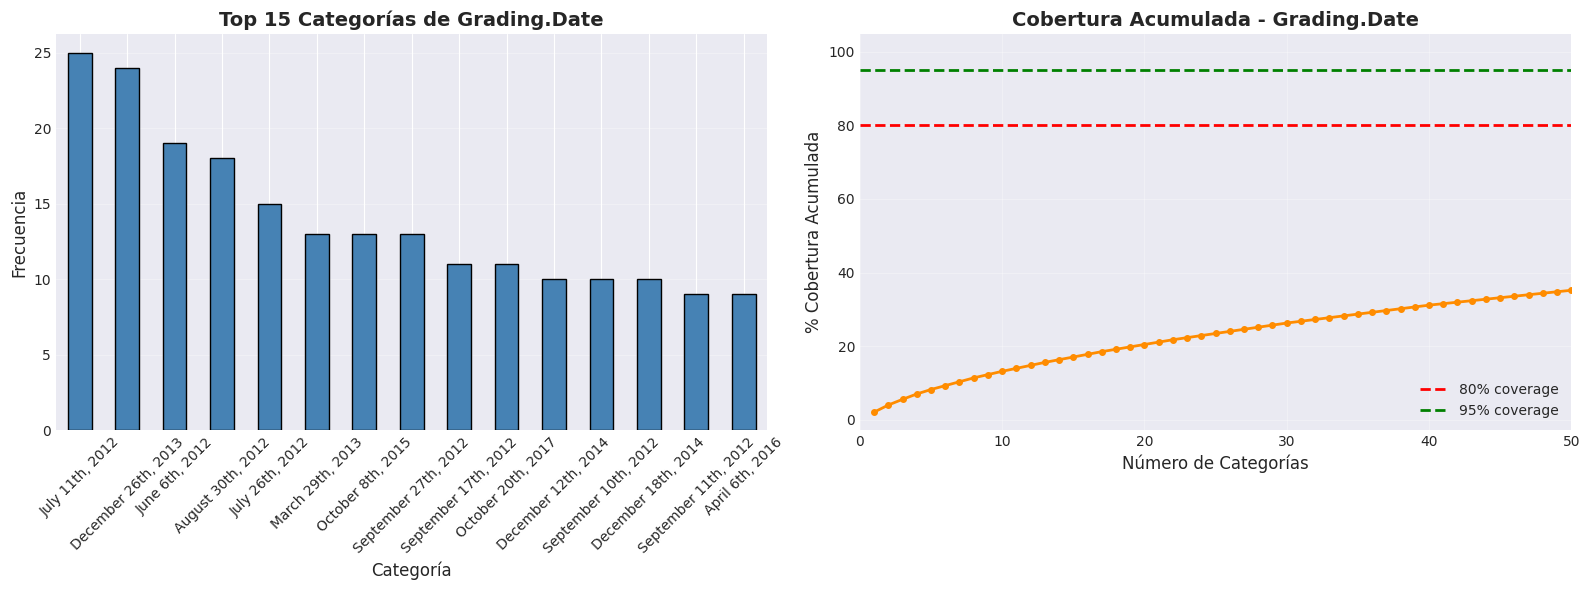




📋 VARIABLE: Owner.1

📊 Estadísticas:
   • Total de valores: 1,234
   • Valores no nulos: 1,227 (99.4%)
   • Valores nulos: 7 (0.6%)
   • Valores únicos: 302

📊 Distribución de valores:

   Top 15 valores más frecuentes:
    1. Juan Luis Alvarado Romero: 155 (12.63%)
    2. Exportadora de Cafe Condor S.A: 53 (4.32%)
    3. Racafe & Cia S.C.A: 53 (4.32%)
    4. Ipanema Coffees: 50 (4.07%)
    5. CQI Taiwan ICP CQI台灣合作夥伴: 46 (3.75%)
    6. NUCOFFEE: 29 (2.36%)
    7. Lin, Che-Hao Krude 林哲豪: 29 (2.36%)
    8. CARCAFE LTDA CI: 27 (2.20%)
    9. The Coffee Source Inc.: 23 (1.87%)
   10. Kona Pacific Farmers Cooperative: 22 (1.79%)
   11. Eileen Koyanagi: 19 (1.55%)
   12. ALFREDO BOJALIL: 19 (1.55%)
   13. AFCA: 17 (1.39%)
   14. BOURBON SPECIALTY COFFEES: 17 (1.39%)
   15. Bismarck Castro: 15 (1.22%)

   💡 Los top 15 valores cubren: 46.8% de los datos
   💡 Valores restantes: 287


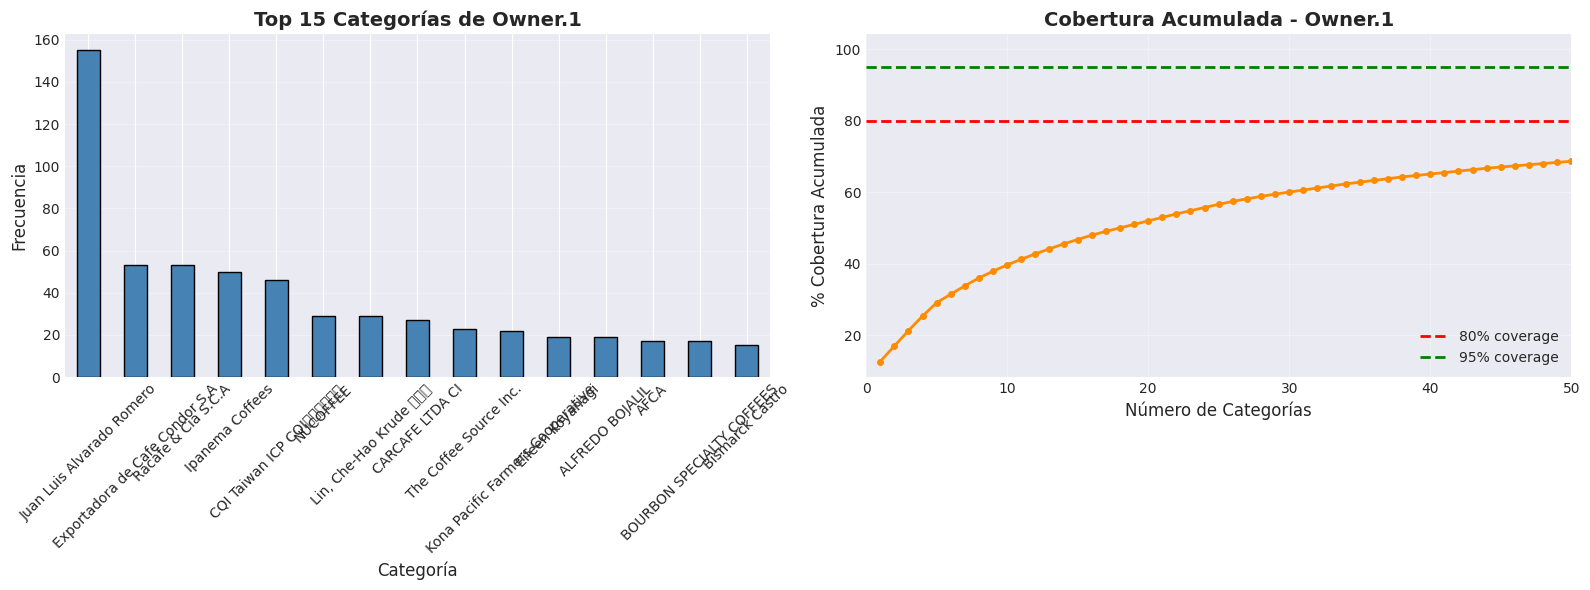




📋 VARIABLE: Variety

📊 Estadísticas:
   • Total de valores: 1,234
   • Valores no nulos: 1,094 (88.7%)
   • Valores nulos: 140 (11.3%)
   • Valores únicos: 29

📊 Distribución de valores:

   Top 15 valores más frecuentes:
    1. Caturra: 256 (23.40%)
    2. Bourbon: 225 (20.57%)
    3. Typica: 209 (19.10%)
    4. Other: 108 (9.87%)
    5. Catuai: 73 (6.67%)
    6. Hawaiian Kona: 37 (3.38%)
    7. Yellow Bourbon: 35 (3.20%)
    8. Mundo Novo: 33 (3.02%)
    9. Catimor: 20 (1.83%)
   10. SL14: 17 (1.55%)
   11. SL28: 14 (1.28%)
   12. Pacas: 13 (1.19%)
   13. Gesha: 12 (1.10%)
   14. SL34: 8 (0.73%)
   15. Pacamara: 8 (0.73%)

   💡 Los top 15 valores cubren: 97.6% de los datos
   💡 Valores restantes: 14


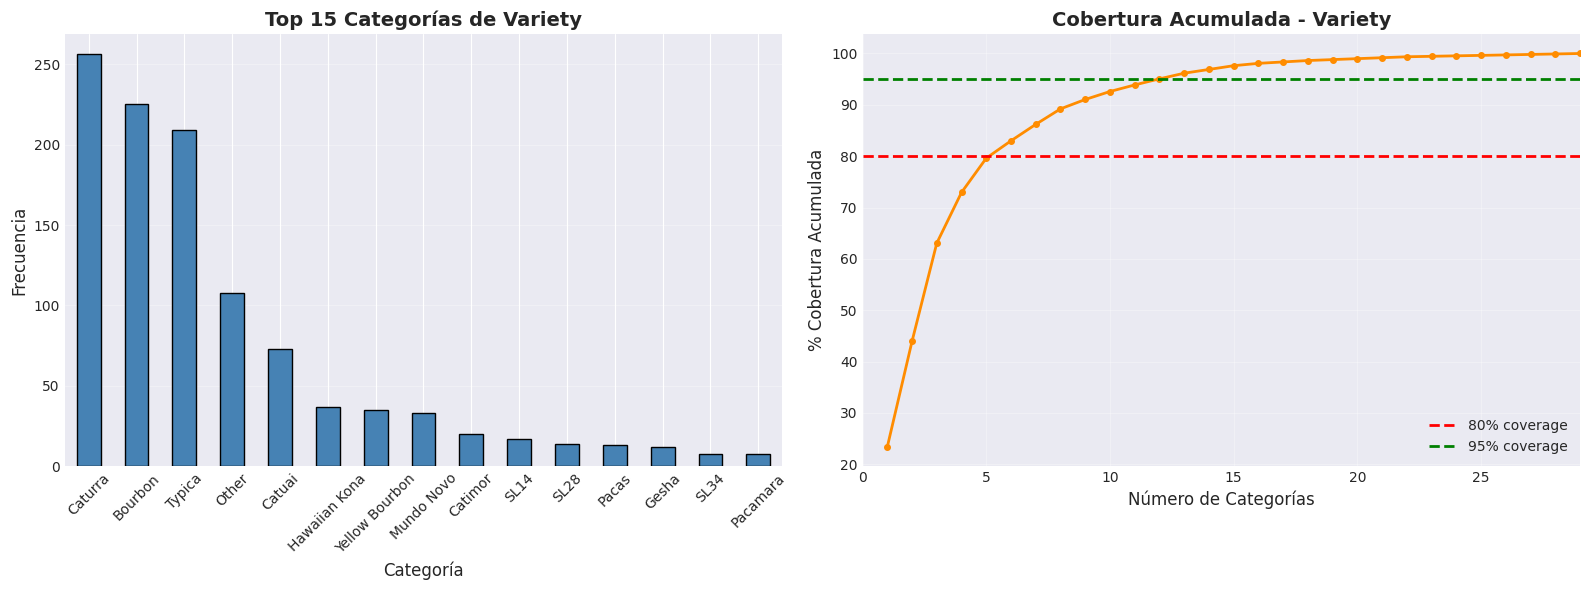




📋 VARIABLE: Processing.Method

📊 Estadísticas:
   • Total de valores: 1,234
   • Valores no nulos: 1,126 (91.2%)
   • Valores nulos: 108 (8.8%)
   • Valores únicos: 5

📊 Distribución de valores:

   Todos los valores (5):
    1. Washed / Wet: 790 (70.16%)
    2. Natural / Dry: 240 (21.31%)
    3. Semi-washed / Semi-pulped: 56 (4.97%)
    4. Other: 26 (2.31%)
    5. Pulped natural / honey: 14 (1.24%)


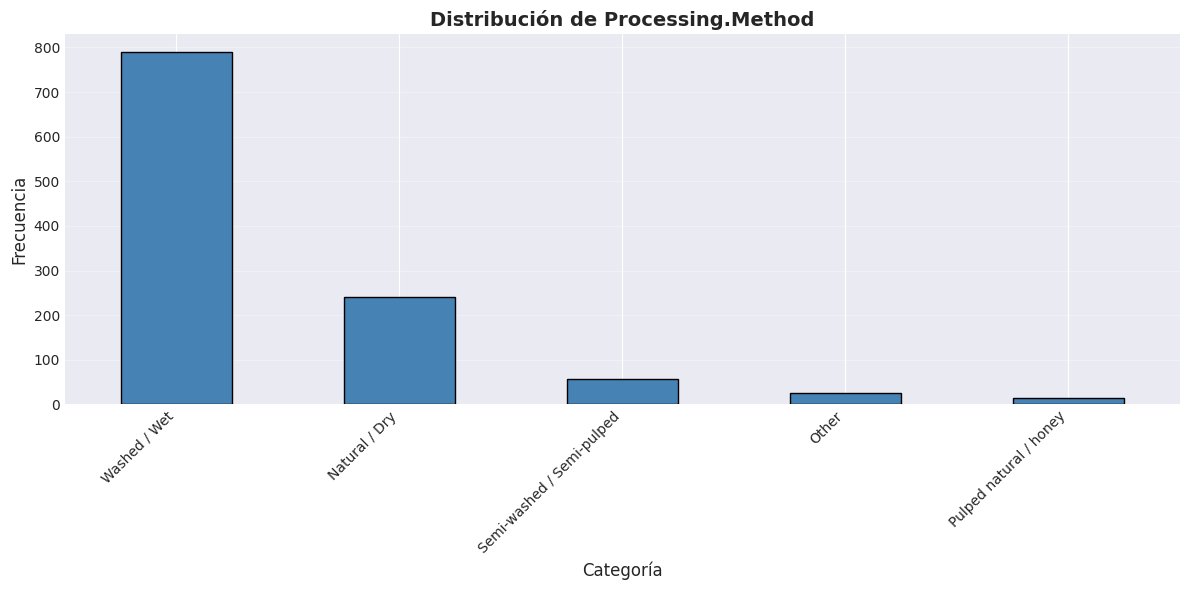




📋 VARIABLE: Color

📊 Estadísticas:
   • Total de valores: 1,234
   • Valores no nulos: 1,040 (84.3%)
   • Valores nulos: 194 (15.7%)
   • Valores únicos: 3

📊 Distribución de valores:

   Todos los valores (3):
    1. Green: 850 (81.73%)
    2. Bluish-Green: 107 (10.29%)
    3. Blue-Green: 83 (7.98%)


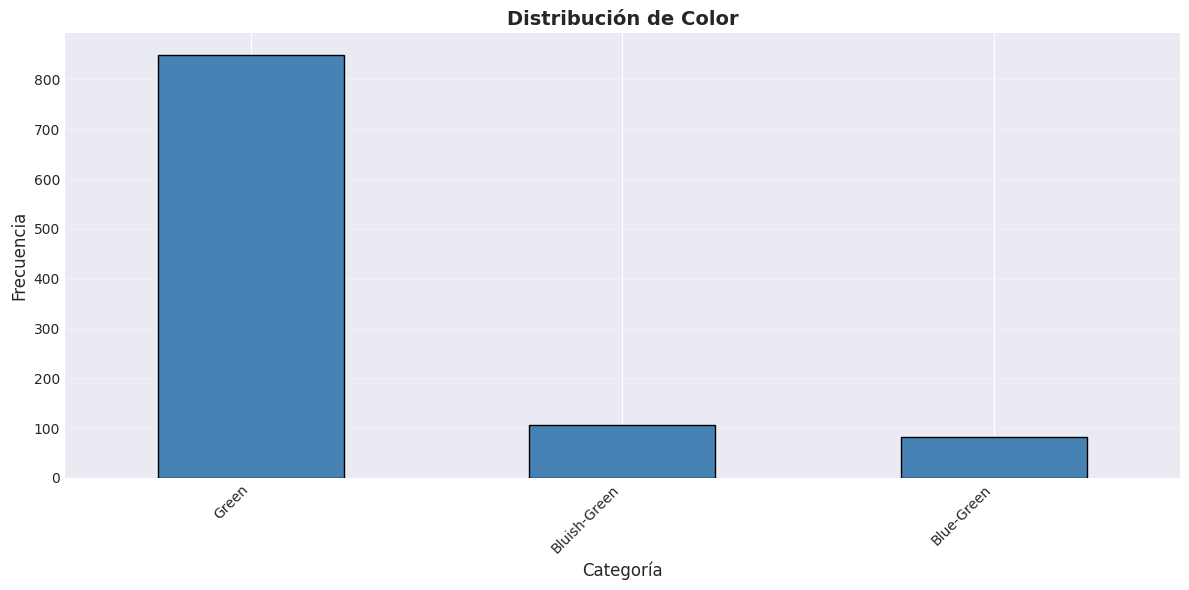




📋 VARIABLE: Expiration

📊 Estadísticas:
   • Total de valores: 1,234
   • Valores no nulos: 1,234 (100.0%)
   • Valores nulos: 0 (0.0%)
   • Valores únicos: 530

📊 Distribución de valores:

   Top 15 valores más frecuentes:
    1. December 26th, 2014: 25 (2.03%)
    2. July 11th, 2013: 25 (2.03%)
    3. June 6th, 2013: 19 (1.54%)
    4. August 30th, 2013: 18 (1.46%)
    5. July 26th, 2013: 15 (1.22%)
    6. October 7th, 2016: 13 (1.05%)
    7. March 29th, 2014: 13 (1.05%)
    8. September 27th, 2013: 13 (1.05%)
    9. October 20th, 2018: 11 (0.89%)
   10. September 17th, 2013: 11 (0.89%)
   11. December 18th, 2015: 10 (0.81%)
   12. December 12th, 2015: 10 (0.81%)
   13. September 10th, 2013: 10 (0.81%)
   14. June 1st, 2018: 9 (0.73%)
   15. April 6th, 2017: 9 (0.73%)

   💡 Los top 15 valores cubren: 17.1% de los datos
   💡 Valores restantes: 515


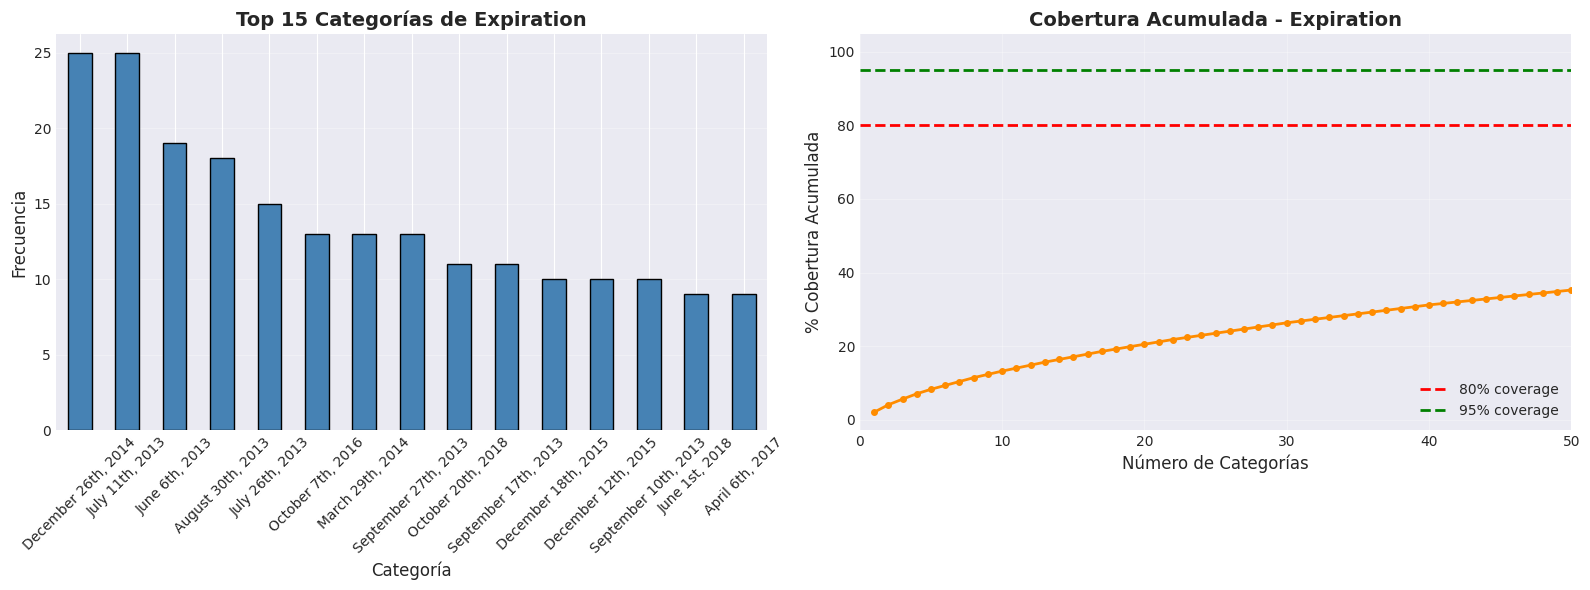




📋 VARIABLE: Certification.Body

📊 Estadísticas:
   • Total de valores: 1,234
   • Valores no nulos: 1,234 (100.0%)
   • Valores nulos: 0 (0.0%)
   • Valores únicos: 25

📊 Distribución de valores:

   Top 15 valores más frecuentes:
    1. Specialty Coffee Association: 241 (19.53%)
    2. AMECAFE: 205 (16.61%)
    3. Almacafé: 163 (13.21%)
    4. Asociacion Nacional Del Café: 155 (12.56%)
    5. Brazil Specialty Coffee Association: 67 (5.43%)
    6. Instituto Hondureño del Café: 60 (4.86%)
    7. Blossom Valley International: 58 (4.70%)
    8. Africa Fine Coffee Association: 49 (3.97%)
    9. Specialty Coffee Association of Costa Rica: 43 (3.48%)
   10. NUCOFFEE: 34 (2.76%)
   11. Uganda Coffee Development Authority: 32 (2.59%)
   12. Kenya Coffee Traders Association: 21 (1.70%)
   13. METAD Agricultural Development plc: 15 (1.22%)
   14. Specialty Coffee Institute of Asia: 13 (1.05%)
   15. Yunnan Coffee Exchange: 12 (0.97%)

   💡 Los top 15 valores cubren: 94.7% de los datos
   💡 Va

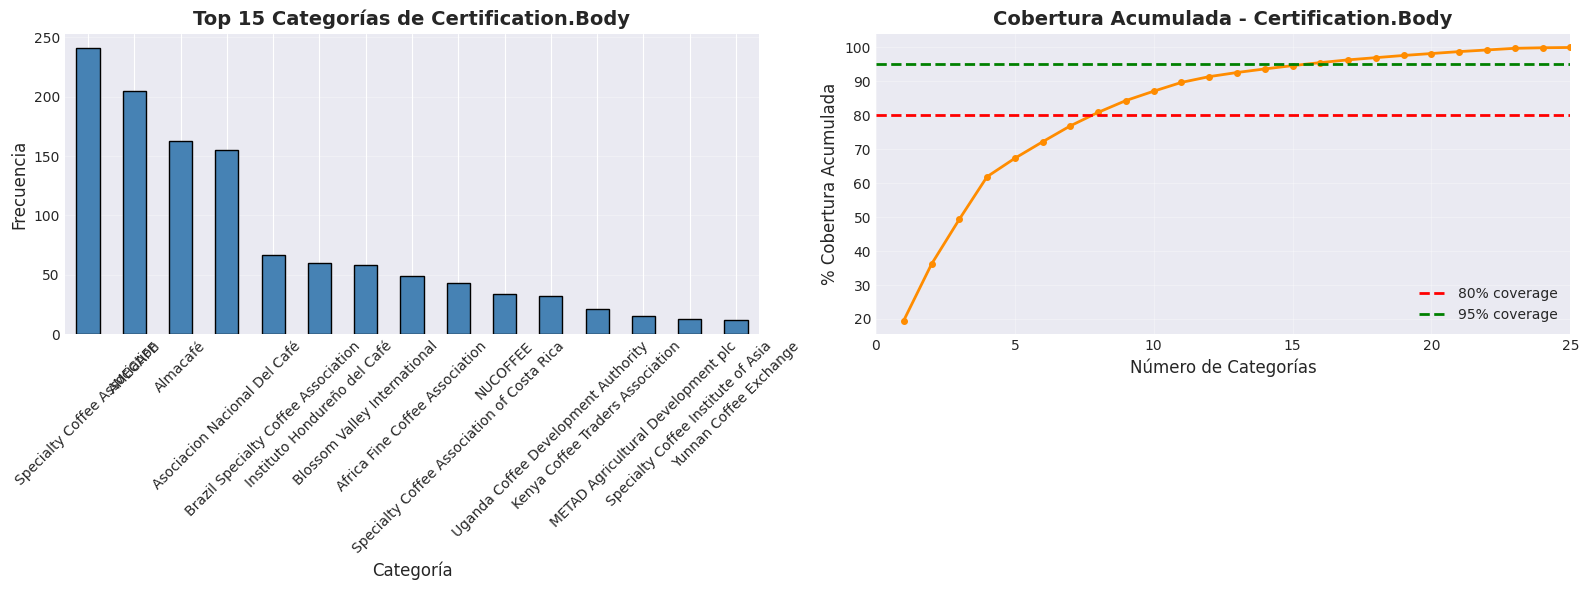




📋 VARIABLE: Certification.Address

📊 Estadísticas:
   • Total de valores: 1,234
   • Valores no nulos: 1,234 (100.0%)
   • Valores nulos: 0 (0.0%)
   • Valores únicos: 31

📊 Distribución de valores:

   Top 15 valores más frecuentes:
    1. 36d0d00a3724338ba7937c52a378d085f2172daa: 223 (18.07%)
    2. 59e396ad6e22a1c22b248f958e1da2bd8af85272: 204 (16.53%)
    3. e493c36c2d076bf273064f7ac23ad562af257a25: 163 (13.21%)
    4. b1f20fe3a819fd6b2ee0eb8fdc3da256604f1e53: 155 (12.56%)
    5. 3297cfa4c538e3dd03f72cc4082c54f7999e1f9d: 67 (5.43%)
    6. b4660a57e9f8cc613ae5b8f02bfce8634c763ab4: 60 (4.86%)
    7. fc45352eee499d8470cf94c9827922fb745bf815: 58 (4.70%)
    8. 073285c0d45e2f5539012d969937e529564fa6fe: 48 (3.89%)
    9. 8e0b118f3cf3121ab27c5387deacdb7d4d2a60b1: 42 (3.40%)
   10. 567f200bcc17a90070cb952647bf88141ad9c80c: 34 (2.76%)
   11. 188fe373b511e21f614564bf86aa4774270d8e04: 22 (1.78%)
   12. ccba45b89d859740b749878be8c6d16fbdb96c2e: 21 (1.70%)
   13. ff7c18ad303d4b603ac3f8cff7e6

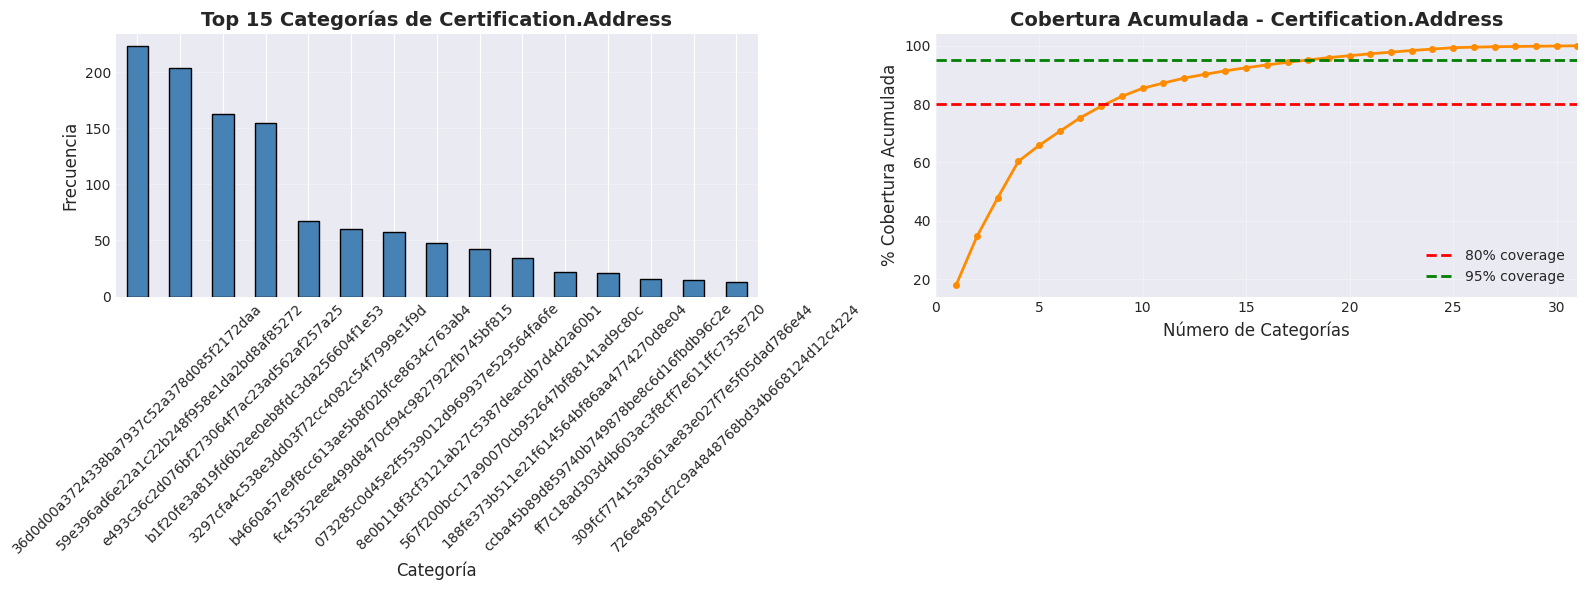




📋 VARIABLE: Certification.Contact

📊 Estadísticas:
   • Total de valores: 1,234
   • Valores no nulos: 1,234 (100.0%)
   • Valores nulos: 0 (0.0%)
   • Valores únicos: 28

📊 Distribución de valores:

   Top 15 valores más frecuentes:
    1. 0878a7d4b9d35ddbf0fe2ce69a2062cceb45a660: 225 (18.23%)
    2. 0eb4ee5b3f47b20b049548a2fd1e7d4a2b70d0a7: 204 (16.53%)
    3. 70d3c0c26f89e00fdae6fb39ff54f0d2eb1c38ab: 163 (13.21%)
    4. 724f04ad10ed31dbb9d260f0dfd221ba48be8a95: 155 (12.56%)
    5. 8900f0bf1d0b2bafe6807a73562c7677d57eb980: 67 (5.43%)
    6. 7f521ca403540f81ec99daec7da19c2788393880: 60 (4.86%)
    7. de73fc9412358b523d3a641501e542f31d2668b0: 58 (4.70%)
    8. c4ab13415cdd69376a93780c0166e7b1a10481ea: 49 (3.97%)
    9. 5eb2b7129d9714c43825e44dc3bca9423de209e9: 43 (3.48%)
   10. aa2ff513ffb9c844462a1fb07c599bce7f3bb53d: 34 (2.76%)
   11. b7614767a5343729bbde3a2777c60ce836aed928: 22 (1.78%)
   12. d752c909a015f3c76224b3c5cc520f8a67afda74: 21 (1.70%)
   13. 352d0cf7f3e9be14dad7df644ad6

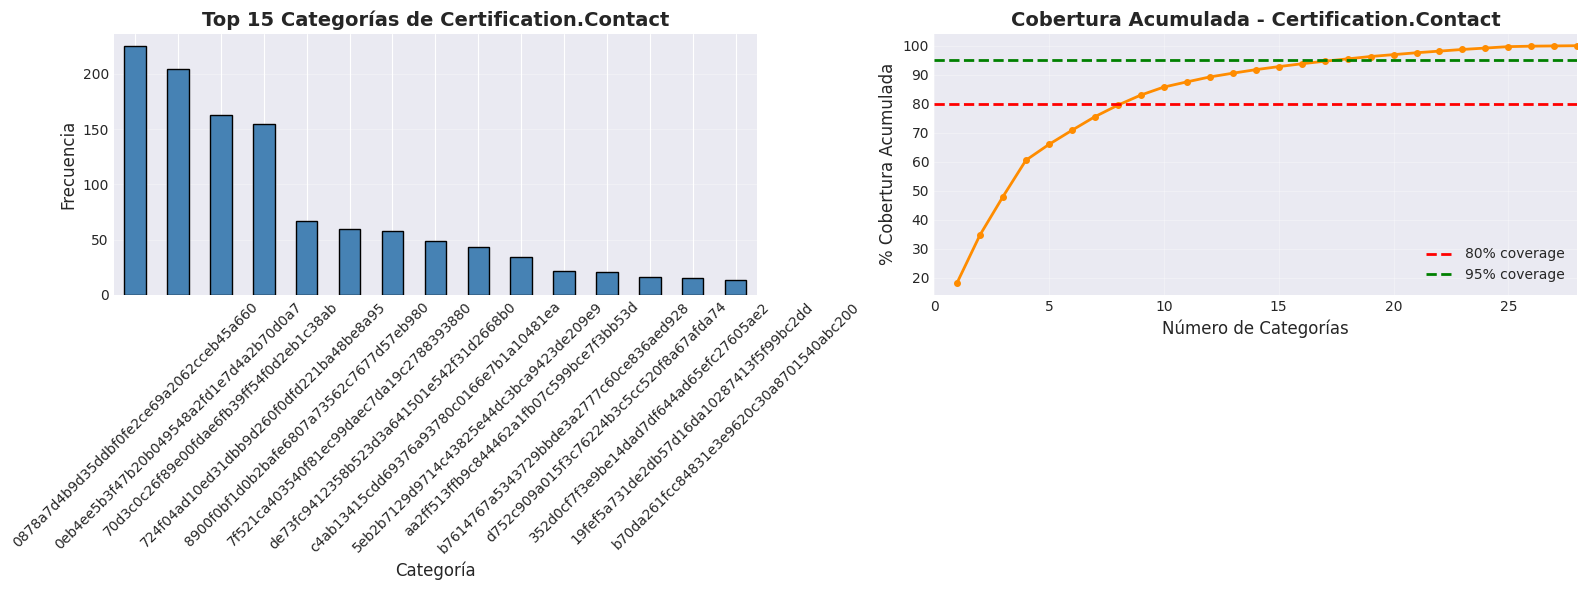




📋 VARIABLE: unit_of_measurement

📊 Estadísticas:
   • Total de valores: 1,234
   • Valores no nulos: 1,234 (100.0%)
   • Valores nulos: 0 (0.0%)
   • Valores únicos: 2

📊 Distribución de valores:

   Todos los valores (2):
    1. m: 1,084 (87.84%)
    2. ft: 150 (12.16%)


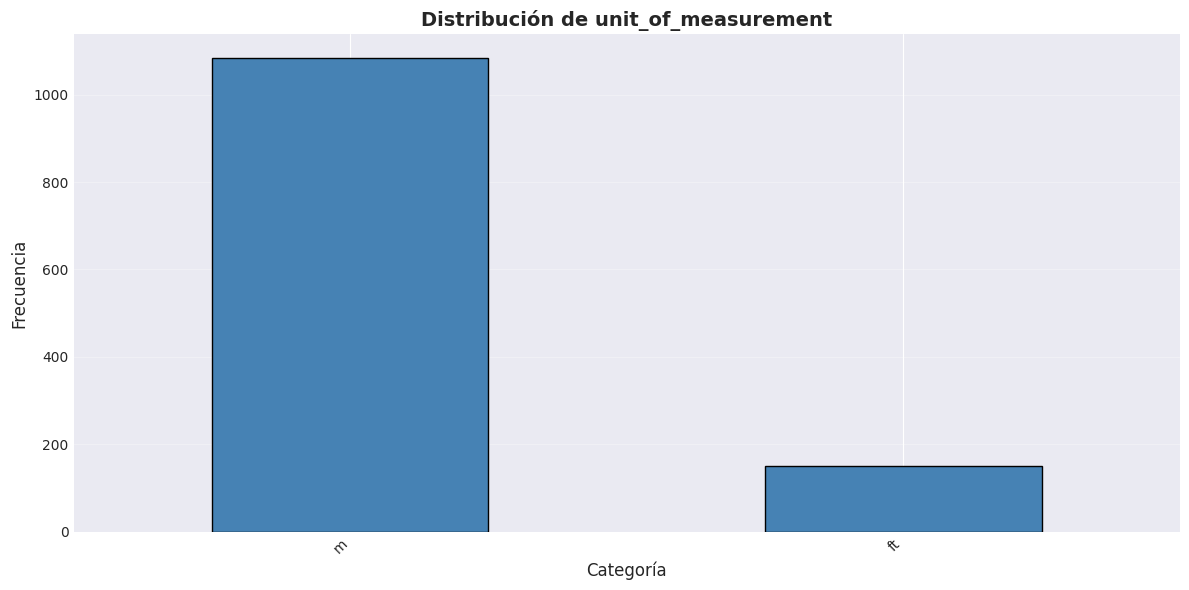




📊 RESUMEN GENERAL

📋 Variables categóricas analizadas: 24

   Variables por cardinalidad:
   • Species: 2 valores únicos - Baja (≤10)
   • Owner: 299 valores únicos - Alta (>30)
   • Country.of.Origin: 36 valores únicos - Alta (>30)
   • Farm.Name: 566 valores únicos - Alta (>30)
   • Lot.Number: 223 valores únicos - Alta (>30)
   • Mill: 455 valores únicos - Alta (>30)
   • ICO.Number: 781 valores únicos - Alta (>30)
   • Company: 274 valores únicos - Alta (>30)
   • Altitude: 391 valores únicos - Alta (>30)
   • Region: 348 valores únicos - Alta (>30)
   • Producer: 680 valores únicos - Alta (>30)
   • Bag.Weight: 50 valores únicos - Alta (>30)
   • In.Country.Partner: 26 valores únicos - Media (10-30)
   • Harvest.Year: 44 valores únicos - Alta (>30)
   • Grading.Date: 531 valores únicos - Alta (>30)
   • Owner.1: 302 valores únicos - Alta (>30)
   • Variety: 29 valores únicos - Media (10-30)
   • Processing.Method: 5 valores únicos - Baja (≤10)
   • Color: 3 valores únicos - Baj

In [103]:
# Análisis detallado de variables categóricas restantes
categorical_vars_remaining = df.select_dtypes(include=['object']).columns.tolist()

print("="*80)
print("ANÁLISIS DETALLADO DE VARIABLES CATEGÓRICAS")
print("="*80)

if len(categorical_vars_remaining) > 0:
    print(f"\n📊 Total de variables categóricas: {len(categorical_vars_remaining)}\n")
    
    for var in categorical_vars_remaining:
        print(f"\n{'='*80}")
        print(f"📋 VARIABLE: {var}")
        print(f"{'='*80}")
        
        # Estadísticas básicas
        total_values = len(df[var])
        non_null = df[var].notna().sum()
        null_values = df[var].isna().sum()
        unique_count = df[var].nunique()
        
        print(f"\n📊 Estadísticas:")
        print(f"   • Total de valores: {total_values:,}")
        print(f"   • Valores no nulos: {non_null:,} ({non_null/total_values*100:.1f}%)")
        print(f"   • Valores nulos: {null_values:,} ({null_values/total_values*100:.1f}%)")
        print(f"   • Valores únicos: {unique_count}")
        
        # Distribución de valores
        print(f"\n📊 Distribución de valores:")
        value_counts = df[var].value_counts()
        
        # Mostrar todos los valores si son pocos, sino top 15
        if unique_count <= 20:
            print(f"\n   Todos los valores ({unique_count}):")
            for idx, (value, count) in enumerate(value_counts.items(), 1):
                pct = (count / non_null) * 100
                print(f"   {idx:2d}. {value}: {count:,} ({pct:.2f}%)")
        else:
            print(f"\n   Top 15 valores más frecuentes:")
            for idx, (value, count) in enumerate(value_counts.head(15).items(), 1):
                pct = (count / non_null) * 100
                print(f"   {idx:2d}. {value}: {count:,} ({pct:.2f}%)")
            
            # Cobertura de top 15
            top15_coverage = (value_counts.head(15).sum() / non_null) * 100
            print(f"\n   💡 Los top 15 valores cubren: {top15_coverage:.1f}% de los datos")
            print(f"   💡 Valores restantes: {unique_count - 15}")
        
        # Visualización
        if unique_count <= 20:
            plt.figure(figsize=(12, 6))
            value_counts.plot(kind='bar', color='steelblue', edgecolor='black')
            plt.title(f'Distribución de {var}', fontsize=14, fontweight='bold')
            plt.xlabel('Categoría', fontsize=12)
            plt.ylabel('Frecuencia', fontsize=12)
            plt.xticks(rotation=45, ha='right')
            plt.grid(axis='y', alpha=0.3)
            plt.tight_layout()
            plt.show()
        else:
            # Gráfico combinado para variables de alta cardinalidad
            fig, axes = plt.subplots(1, 2, figsize=(16, 6))
            
            # Top 15 valores
            value_counts.head(15).plot(kind='bar', ax=axes[0], 
                                       color='steelblue', edgecolor='black')
            axes[0].set_title(f'Top 15 Categorías de {var}', fontsize=14, fontweight='bold')
            axes[0].set_xlabel('Categoría', fontsize=12)
            axes[0].set_ylabel('Frecuencia', fontsize=12)
            axes[0].tick_params(axis='x', rotation=45)
            axes[0].grid(axis='y', alpha=0.3)
            
            # Distribución acumulada
            cumsum_pct = (value_counts.cumsum() / non_null) * 100
            axes[1].plot(range(1, len(cumsum_pct) + 1), cumsum_pct, 
                        marker='o', linewidth=2, markersize=4, color='darkorange')
            axes[1].axhline(y=80, color='red', linestyle='--', linewidth=2, label='80% coverage')
            axes[1].axhline(y=95, color='green', linestyle='--', linewidth=2, label='95% coverage')
            axes[1].set_title(f'Cobertura Acumulada - {var}', fontsize=14, fontweight='bold')
            axes[1].set_xlabel('Número de Categorías', fontsize=12)
            axes[1].set_ylabel('% Cobertura Acumulada', fontsize=12)
            axes[1].legend()
            axes[1].grid(alpha=0.3)
            axes[1].set_xlim(0, min(50, len(cumsum_pct)))
            
            plt.tight_layout()
            plt.show()
        
        print(f"\n")
    
    # Resumen final
    print(f"\n{'='*80}")
    print(f"📊 RESUMEN GENERAL")
    print(f"{'='*80}")
    print(f"\n📋 Variables categóricas analizadas: {len(categorical_vars_remaining)}")
    print(f"\n   Variables por cardinalidad:")
    for var in categorical_vars_remaining:
        unique = df[var].nunique()
        if unique <= 10:
            category = "Baja (≤10)"
        elif unique <= 30:
            category = "Media (10-30)"
        else:
            category = "Alta (>30)"
        print(f"   • {var}: {unique} valores únicos - {category}")
    
else:
    print("\n⚠️  No hay variables categóricas en el dataset actual.")
    print("   Todas las variables pueden haber sido codificadas o eliminadas previamente.")

print(f"\n{'='*80}")

# Tabla de cardinalidad

In [104]:
categorical_vars_analysis = df.select_dtypes(include=['object']).columns.tolist()

print("="*80)
print("TABLA DE CARDINALIDAD - VARIABLES CATEGÓRICAS")
print("="*80)

if len(categorical_vars_analysis) == 0:
    print("\n⚠️  No hay variables categóricas en el dataset actual.")
    print("   Las variables categóricas pueden haber sido eliminadas o codificadas previamente.")
else:
    cardinality_table = []
    
    for var in categorical_vars_analysis:
        total_values = len(df)
        non_null_values = df[var].notna().sum()
        null_values = df[var].isna().sum()
        unique_values = df[var].nunique()
        null_pct = (null_values / total_values) * 100
        cardinality_ratio = (unique_values / non_null_values * 100) if non_null_values > 0 else 0
        
        cardinality_table.append({
            'Variable': var,
            'Total_Valores': total_values,
            'No_Nulos': non_null_values,
            'Nulos': null_values,
            'Nulos_%': round(null_pct, 2),
            'Valores_Unicos': unique_values,
            'Cardinalidad_%': round(cardinality_ratio, 2)
        })
    
    # Crear DataFrame de cardinalidad
    cardinality_df = pd.DataFrame(cardinality_table)
    cardinality_df = cardinality_df.sort_values('Cardinalidad_%', ascending=False)
    
    print(f"\n📊 Total de variables categóricas analizadas: {len(categorical_vars_analysis)}\n")
    
    # Mostrar tabla completa
    display(cardinality_df)
    
    # Clasificar variables por cardinalidad
    print(f"\n📊 CLASIFICACIÓN POR CARDINALIDAD:")
    print(f"━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")
    
    baja = cardinality_df[cardinality_df['Cardinalidad_%'] <= 10]
    media = cardinality_df[(cardinality_df['Cardinalidad_%'] > 10) & (cardinality_df['Cardinalidad_%'] <= 40)]
    alta = cardinality_df[cardinality_df['Cardinalidad_%'] > 40]
    
    print(f"\n✅ BAJA CARDINALIDAD (≤10%):")
    print(f"   • Cantidad: {len(baja)}")
    if len(baja) > 0:
        print(f"   • Variables: {', '.join(baja['Variable'].tolist())}")
        print(f"   • Recomendación: MANTENER e imputar")
    
    print(f"\n⚠️  CARDINALIDAD MEDIA (10-40%):")
    print(f"   • Cantidad: {len(media)}")
    if len(media) > 0:
        print(f"   • Variables: {', '.join(media['Variable'].tolist())}")
        print(f"   • Recomendación: EVALUAR caso por caso")
    
    print(f"\n❌ ALTA CARDINALIDAD (>40%):")
    print(f"   • Cantidad: {len(alta)}")
    if len(alta) > 0:
        print(f"   • Variables: {', '.join(alta['Variable'].tolist())}")
        print(f"   • Recomendación: ELIMINAR o agrupar en categorías")

print(f"\n" + "="*80)


TABLA DE CARDINALIDAD - VARIABLES CATEGÓRICAS

📊 Total de variables categóricas analizadas: 24



,Variable,Total_Valores,No_Nulos,Nulos,Nulos_%,Valores_Unicos,Cardinalidad_%
4,Lot.Number,1234,271,963,78.04,223,82.29
6,ICO.Number,1234,1102,132,10.70,781,70.87
10,Producer,1234,1083,151,12.24,680,62.79
3,Farm.Name,1234,958,276,22.37,566,59.08
5,Mill,1234,1010,224,18.15,455,45.05
14,Grading.Date,1234,1234,0,0.00,531,43.03
19,Expiration,1234,1234,0,0.00,530,42.95
8,Altitude,1234,1107,127,10.29,391,35.32
9,Region,1234,1225,9,0.73,348,28.41
7,Company,1234,1086,148,11.99,274,25.23



📊 CLASIFICACIÓN POR CARDINALIDAD:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

✅ BAJA CARDINALIDAD (≤10%):
   • Cantidad: 12
   • Variables: Bag.Weight, Harvest.Year, Country.of.Origin, Variety, Certification.Address, Certification.Contact, In.Country.Partner, Certification.Body, Processing.Method, Color, Species, unit_of_measurement
   • Recomendación: MANTENER e imputar

⚠️  CARDINALIDAD MEDIA (10-40%):
   • Cantidad: 5
   • Variables: Altitude, Region, Company, Owner.1, Owner
   • Recomendación: EVALUAR caso por caso

❌ ALTA CARDINALIDAD (>40%):
   • Cantidad: 7
   • Variables: Lot.Number, ICO.Number, Producer, Farm.Name, Mill, Grading.Date, Expiration
   • Recomendación: ELIMINAR o agrupar en categorías



# Tabla de cardinalidad para las variables categoricas

* Eliminaremos la columna Lot.number por que supera el 70% valores faltantes.
* Entre las columnas que cuentan con el 20% y 50% de valores faltantes decidimos:
    * Farm.name va a ser eliminada por alta cardinalidad y su datos faltantes
    * Mill se eliminara por la poca relevancia y alta cardinalidad
    * Color se eliminara en las primeras pruebas porque posiblemente las 3 categorias son equivalentes.
* Entre las columnas que estan con menos del 20% de valores faltantes decidimos:
    * Producer se va a eliminar por alta cardinalidad y poca revelancia
    * ICO.Number se va a eliminar porque no sigue el estandar.
    * Owner1 se va eliminar porque existe otra columna equivalente, dandonos duplicidad-
    * Certification.Contact este valor es especifico por catador, esto podria sesgar al modelo por catador y no por la calidad del cafe.
    * Certification.Address se eliminara porque usaremos la columna altitud.
    * Region se eliminara por que usaremos altitud y otras variables, ademas de que cuenta con una alta cardinalidad.
    * Company se eliminara por sus valores nulos, la dificultad de imputacion y la posible poca relevancia.
    * Harvest.Year se eliminara por las posibles problematicas de usar one-hot encode y el poco sentido de usarla como ordinal.
    * Bag.Weight se eliminara por su posible poca relevancia para la predicir la calidad.

De las variables que dejaremos tenemos que hacerle lo siguiente:

* Para Grading.Date y Expiration se validara el formato de las fechas y se convertiran en formato estandar para en los notebooks hacer operaciones entre ellas.

* Para Altitud debemos convertirlos en un unico valor numerico. Que en cada muestra solo haya un valor de altitud. Se podria usar un promedio cuando aparezcan todo y comprobar la integridad de los datos.

* Para In.Country.Partner y Variety se hara procesamiento a las cadenas de texto para agrupar valores similares por sensibilidad de escritura( Normalizaicon de texto). Por ejemplo tildes, Mayusculas, simbolos o caracteres especiales.

* Para Method, a los datos nulos se agregaran a un categoria llamada "Unknown"




### 2.2 Eliminación de Variables con >70% Valores Faltantes

Según el EDA, **Lot.Number** tiene >70% de valores faltantes y debe ser eliminada.


In [105]:
# Recalcular valores faltantes después de eliminar muestras
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100
missing_df = pd.DataFrame({
    'Valores Faltantes': missing_data,
    'Porcentaje': missing_percent
}).sort_values(by='Porcentaje', ascending=False)

print("="*80)
print("ANÁLISIS DE VALORES FALTANTES (POST-ELIMINACIÓN DE MUESTRAS)")
print("="*80)
print(f"\n📊 Top 15 variables con más valores faltantes:")
display(missing_df[missing_df['Valores Faltantes'] > 0].head(15))


ANÁLISIS DE VALORES FALTANTES (POST-ELIMINACIÓN DE MUESTRAS)

📊 Top 15 variables con más valores faltantes:


,Valores Faltantes,Porcentaje
Lot.Number,963,78.038898
Farm.Name,276,22.366288
Mill,224,18.152350
Color,194,15.721232
Producer,151,12.236629
Company,148,11.993517
Variety,140,11.345219
ICO.Number,132,10.696921
altitude_low_meters,129,10.453809
altitude_mean_meters,129,10.453809


In [106]:
# Eliminar variables con >70% missing
threshold = 70
columns_to_drop = missing_df[missing_df['Porcentaje'] > threshold].index.tolist()

print("="*80)
print("ELIMINACIÓN DE VARIABLES CON >70% MISSING")
print("="*80)

print(f"\n📊 Estado Antes:")
print(f"  - Dimensiones: {df.shape}")
print(f"  - Variables totales: {df.shape[1]}")

if columns_to_drop:
    print(f"\n🗑️  Variables a eliminar:")
    for col in columns_to_drop:
        pct = missing_df.loc[col, 'Porcentaje']
        print(f"  - {col}: {pct:.1f}% missing")
    
    df = df.drop(columns=columns_to_drop)
else:
    print(f"\n✅ No hay variables con >{threshold}% missing")

print(f"\n📊 Estado Después:")
print(f"  - Dimensiones: {df.shape}")
print(f"  - Variables totales: {df.shape[1]}")
print(f"  - Columnas eliminadas: {len(columns_to_drop)}")

print(f"\n✅ Variables con >{threshold}% missing eliminadas")


ELIMINACIÓN DE VARIABLES CON >70% MISSING

📊 Estado Antes:
  - Dimensiones: (1234, 43)
  - Variables totales: 43

🗑️  Variables a eliminar:
  - Lot.Number: 78.0% missing

📊 Estado Después:
  - Dimensiones: (1234, 42)
  - Variables totales: 42
  - Columnas eliminadas: 1

✅ Variables con >70% missing eliminadas


Dejaremos Grading.date y Expiracion para hacer un analisis de estos. De tal manera que podamos considerarlas unirlas en una.

## 5. Verificación y Validación del Dataset Limpio

Verificaremos que el dataset procesado cumple con todos los requisitos de calidad antes de guardarlo.


In [107]:
# Verificación completa del dataset
print("="*80)
print("VERIFICACIÓN FINAL DEL DATASET PROCESADO")
print("="*80)

# 1. Dimensiones
print(f"\n📊 DIMENSIONES:")
print(f"   • Dataset original: {merged_df.shape}")
print(f"   • Dataset procesado: {df.shape}")
print(f"   • Muestras eliminadas: {merged_df.shape[0] - df.shape[0]} ({(merged_df.shape[0] - df.shape[0])/merged_df.shape[0]*100:.1f}%)")
print(f"   • Features finales: {df.shape[1]}")

# 2. Valores faltantes
total_missing = df.isnull().sum().sum()
print(f"\n📊 VALORES FALTANTES:")
print(f"   • Total: {total_missing}")
if total_missing == 0:
    print(f"   • ✅ NO HAY VALORES FALTANTES")
else:
    print(f"   • ⚠️  Aún hay {total_missing} valores faltantes")

# 3. Duplicados
duplicates = df.duplicated().sum()
print(f"\n📊 DUPLICADOS:")
print(f"   • Registros duplicados: {duplicates}")
if duplicates == 0:
    print(f"   • ✅ NO HAY DUPLICADOS")

# 4. Tipos de datos
print(f"\n📊 TIPOS DE DATOS:")
print(f"   • Variables numéricas: {len(df.select_dtypes(include=['int64', 'float64']).columns)}")
print(f"   • Variables categóricas: {len(df.select_dtypes(include=['object']).columns)}")

# 5. Variable objetivo
if target_var in df.columns:
    print(f"\n📊 VARIABLE OBJETIVO ({target_var}):")
    print(f"   • Valores nulos: {df[target_var].isna().sum()}")
    print(f"   • Rango: [{df[target_var].min():.2f}, {df[target_var].max():.2f}]")
    print(f"   • Media: {df[target_var].mean():.2f} ± {df[target_var].std():.2f}")
    print(f"   • ✅ Variable objetivo intacta")

# 6. Resumen de transformaciones
print(f"\n📊 RESUMEN DE TRANSFORMACIONES APLICADAS:")


print(f"\n" + "="*80)
print("✅ VERIFICACIÓN COMPLETADA - DATASET LISTO PARA MODELADO")
print("="*80)


VERIFICACIÓN FINAL DEL DATASET PROCESADO

📊 DIMENSIONES:
   • Dataset original: (1339, 43)
   • Dataset procesado: (1234, 42)
   • Muestras eliminadas: 105 (7.8%)
   • Features finales: 42

📊 VALORES FALTANTES:
   • Total: 1921
   • ⚠️  Aún hay 1921 valores faltantes

📊 DUPLICADOS:
   • Registros duplicados: 0
   • ✅ NO HAY DUPLICADOS

📊 TIPOS DE DATOS:
   • Variables numéricas: 19
   • Variables categóricas: 23

📊 VARIABLE OBJETIVO (Total.Cup.Points):
   • Valores nulos: 0
   • Rango: [0.00, 90.58]
   • Media: 82.04 ± 3.54
   • ✅ Variable objetivo intacta

📊 RESUMEN DE TRANSFORMACIONES APLICADAS:

✅ VERIFICACIÓN COMPLETADA - DATASET LISTO PARA MODELADO


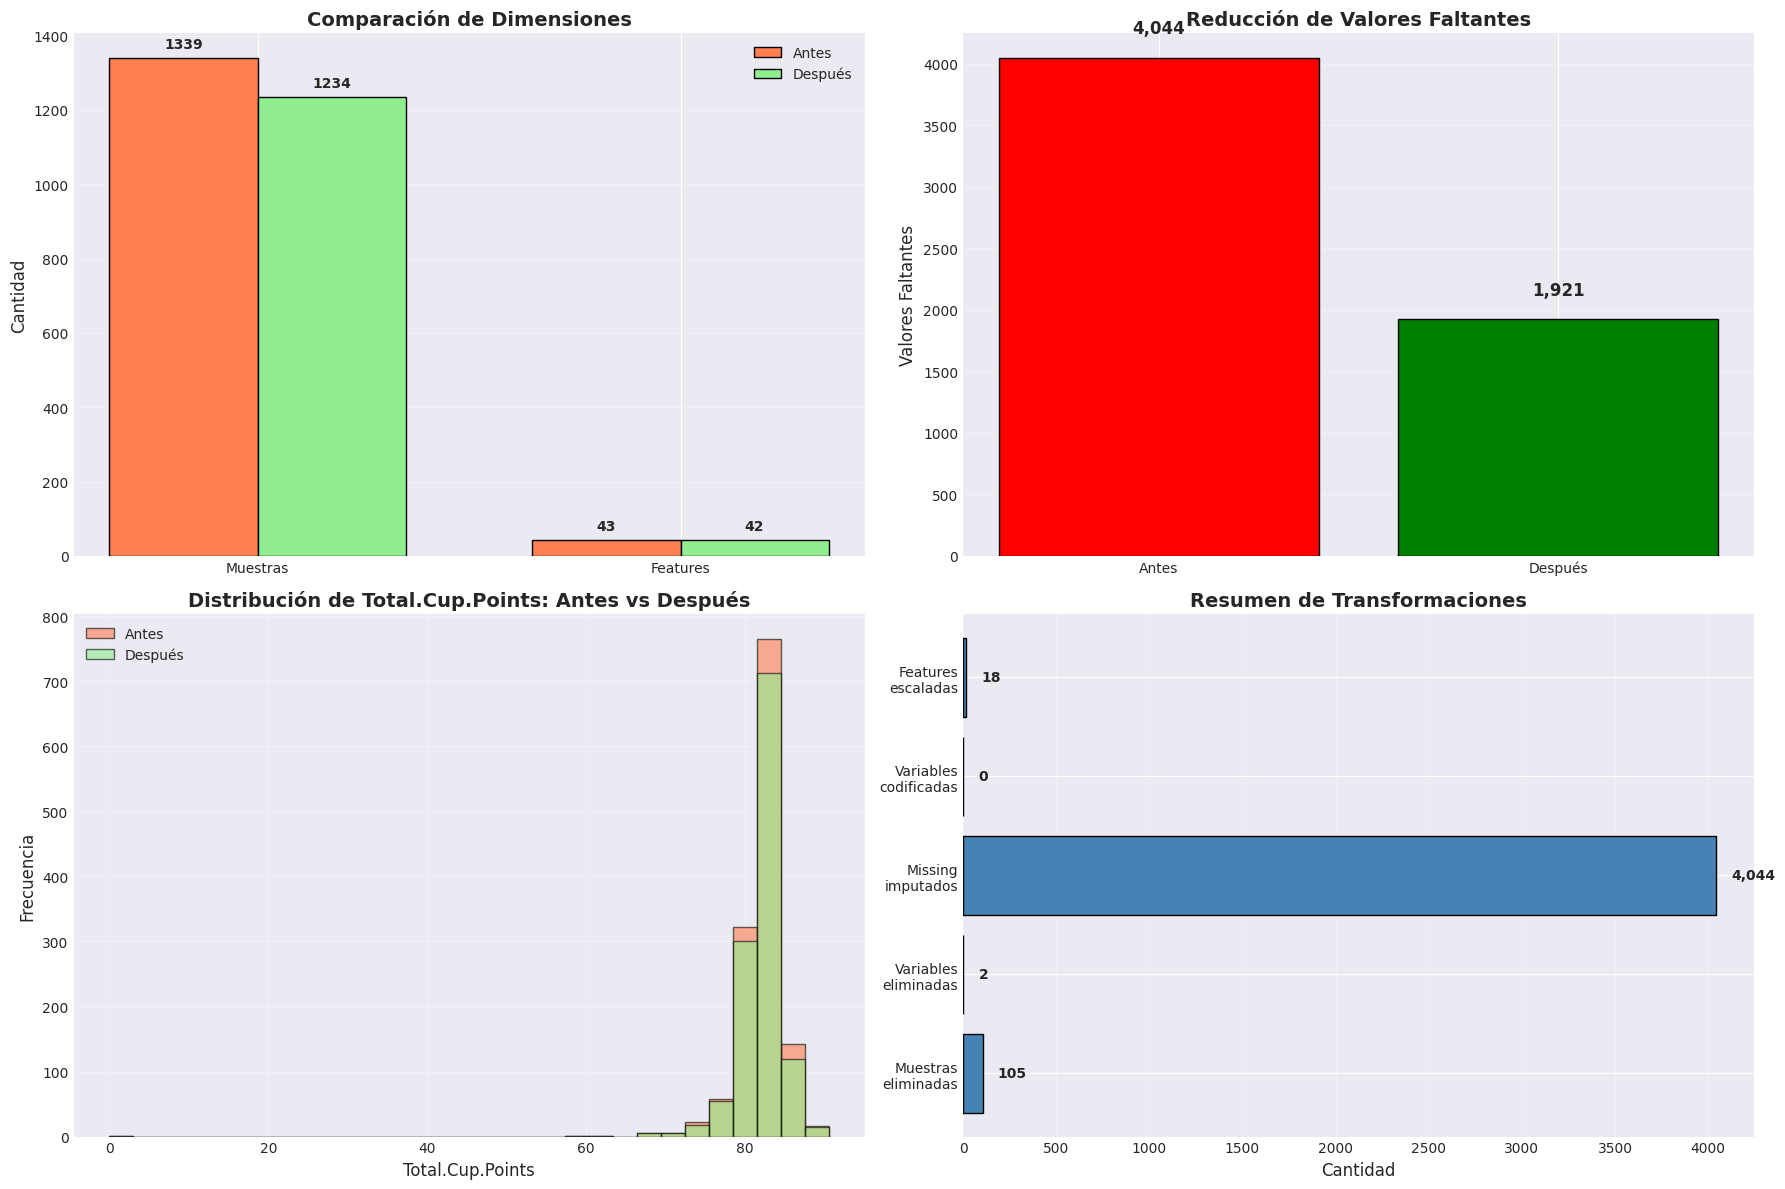


✅ Visualización comparativa guardada en: reports/figures/preprocessing_comparison.png


In [108]:
# Comparación visual: Antes vs Después
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Comparación de dimensiones
ax1 = axes[0, 0]
categories = ['Muestras', 'Features']
before = [merged_df.shape[0], merged_df.shape[1]]
after = [df.shape[0], df.shape[1]]
x = np.arange(len(categories))
width = 0.35

ax1.bar(x - width/2, before, width, label='Antes', color='coral', edgecolor='black')
ax1.bar(x + width/2, after, width, label='Después', color='lightgreen', edgecolor='black')
ax1.set_ylabel('Cantidad', fontsize=12)
ax1.set_title('Comparación de Dimensiones', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(categories)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Agregar valores en las barras
for i, (b, a) in enumerate(zip(before, after)):
    ax1.text(i - width/2, b + max(before)*0.02, str(b), ha='center', fontsize=10, fontweight='bold')
    ax1.text(i + width/2, a + max(before)*0.02, str(a), ha='center', fontsize=10, fontweight='bold')

# 2. Comparación de valores faltantes
ax2 = axes[0, 1]
missing_before = merged_df.isnull().sum().sum()
missing_after = df.isnull().sum().sum()
ax2.bar(['Antes', 'Después'], [missing_before, missing_after], 
        color=['red', 'green'], edgecolor='black')
ax2.set_ylabel('Valores Faltantes', fontsize=12)
ax2.set_title('Reducción de Valores Faltantes', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# Agregar valores
ax2.text(0, missing_before + max(missing_before, missing_after)*0.05, 
         f'{missing_before:,}', ha='center', fontsize=12, fontweight='bold')
ax2.text(1, missing_after + max(missing_before, missing_after)*0.05, 
         f'{missing_after:,}', ha='center', fontsize=12, fontweight='bold')

# 3. Distribución de la variable objetivo (antes y después)
ax3 = axes[1, 0]
ax3.hist(merged_df[target_var].dropna(), bins=30, alpha=0.6, 
         label='Antes', color='coral', edgecolor='black')
ax3.hist(df[target_var].dropna(), bins=30, alpha=0.6, 
         label='Después', color='lightgreen', edgecolor='black')
ax3.set_xlabel(target_var, fontsize=12)
ax3.set_ylabel('Frecuencia', fontsize=12)
ax3.set_title(f'Distribución de {target_var}: Antes vs Después', 
              fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)

# 4. Resumen de transformaciones
ax4 = axes[1, 1]
transformations = [
    'Muestras\neliminadas',
    'Variables\neliminadas',
    'Missing\nimputados',
    'Variables\ncodificadas',
    'Features\nescaladas'
]
counts = [
    merged_df.shape[0] - df.shape[0],
    len(columns_to_drop) + len(vars_to_drop_cardinality) if 'vars_to_drop_cardinality' in locals() else 0,
    missing_before,
    len(categorical_vars_current) if 'categorical_vars_current' in locals() else 0,
    len(numerical_vars_to_scale) if 'numerical_vars_to_scale' in locals() else 0
]

bars = ax4.barh(transformations, counts, color='steelblue', edgecolor='black')
ax4.set_xlabel('Cantidad', fontsize=12)
ax4.set_title('Resumen de Transformaciones', fontsize=14, fontweight='bold')
ax4.grid(axis='x', alpha=0.3)

# Agregar valores en las barras
for bar, count in zip(bars, counts):
    width = bar.get_width()
    ax4.text(width + max(counts)*0.02, bar.get_y() + bar.get_height()/2, 
             f'{count:,}', ha='left', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(output_path / 'preprocessing_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✅ Visualización comparativa guardada en: reports/figures/preprocessing_comparison.png")


## 6. Guardar Dataset Procesado

Guardaremos el dataset limpio y procesado en la carpeta `data/processed/` para su uso en notebooks posteriores.


In [109]:
# Guardar dataset procesado
processed_path = project_root / 'data' / 'processed'
processed_path.mkdir(parents=True, exist_ok=True)

output_file = processed_path / 'coffee_cleaned.csv'

print("="*80)
print("GUARDANDO DATASET PROCESADO")
print("="*80)

# Guardar dataset
df.to_csv(output_file, index=False)

print(f"\n✅ Dataset guardado exitosamente:")
print(f"   • Ruta: {output_file}")
print(f"   • Tamaño: {output_file.stat().st_size / 1024 / 1024:.2f} MB")
print(f"   • Dimensiones: {df.shape}")
print(f"   • Muestras: {df.shape[0]:,}")
print(f"   • Features: {df.shape[1]}")

# Guardar información del procesamiento
preprocessing_summary = {
    'original_samples': int(merged_df.shape[0]),
    'original_features': int(merged_df.shape[1]),
    'processed_samples': int(df.shape[0]),
    'processed_features': int(df.shape[1]),
    'samples_removed': int(merged_df.shape[0] - df.shape[0]),
    'samples_removed_pct': float((merged_df.shape[0] - df.shape[0]) / merged_df.shape[0] * 100),
    'features_added': int(df.shape[1] - merged_df.shape[1]),
    'missing_values_before': int(merged_df.isnull().sum().sum()),
    'missing_values_after': int(df.isnull().sum().sum()),
    'transformations_applied': [
        
    ]
}

# Guardar resumen en JSON
summary_file = processed_path / 'preprocessing_summary.json'
with open(summary_file, 'w') as f:
    json.dump(preprocessing_summary, f, indent=2)

print(f"\n✅ Resumen del procesamiento guardado:")
print(f"   • Ruta: {summary_file}")

print(f"\n" + "="*80)
print("✅ PREPROCESAMIENTO COMPLETADO EXITOSAMENTE")
print("="*80)
print(f"\n📈 Próximos pasos:")
print(f"   1. Ejecutar notebook 03_feature_engineering.ipynb")
print(f"   2. Realizar análisis de correlación avanzado")
print(f"   3. Seleccionar features más relevantes")
print(f"   4. Preparar datos para modelado")


GUARDANDO DATASET PROCESADO

✅ Dataset guardado exitosamente:
   • Ruta: /home/rickcontreras/proyectos/coffee-quality-prediction/data/processed/coffee_cleaned.csv
   • Tamaño: 0.54 MB
   • Dimensiones: (1234, 42)
   • Muestras: 1,234
   • Features: 42

✅ Resumen del procesamiento guardado:
   • Ruta: /home/rickcontreras/proyectos/coffee-quality-prediction/data/processed/preprocessing_summary.json

✅ PREPROCESAMIENTO COMPLETADO EXITOSAMENTE

📈 Próximos pasos:
   1. Ejecutar notebook 03_feature_engineering.ipynb
   2. Realizar análisis de correlación avanzado
   3. Seleccionar features más relevantes
   4. Preparar datos para modelado

✅ Dataset guardado exitosamente:
   • Ruta: /home/rickcontreras/proyectos/coffee-quality-prediction/data/processed/coffee_cleaned.csv
   • Tamaño: 0.54 MB
   • Dimensiones: (1234, 42)
   • Muestras: 1,234
   • Features: 42

✅ Resumen del procesamiento guardado:
   • Ruta: /home/rickcontreras/proyectos/coffee-quality-prediction/data/processed/preprocessing_

## 7. Resumen Ejecutivo del Preprocesamiento

Documentación completa de las decisiones y transformaciones aplicadas al dataset.


In [110]:
print("="*80)
print("RESUMEN EJECUTIVO DEL PREPROCESAMIENTO DE DATOS")
print("="*80)

executive_summary = f"""
📊 ESTADÍSTICAS GENERALES:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

DATASET ORIGINAL:
  • Muestras: {merged_df.shape[0]:,}
  • Features: {merged_df.shape[1]}
  • Valores faltantes: {merged_df.isnull().sum().sum():,}
  • % de missing: {(merged_df.isnull().sum().sum() / (merged_df.shape[0] * merged_df.shape[1]) * 100):.2f}%

DATASET PROCESADO:
  • Muestras: {df.shape[0]:,}
  • Features: {df.shape[1]}
  • Valores faltantes: {df.isnull().sum().sum()}
  • % de missing: {(df.isnull().sum().sum() / (df.shape[0] * df.shape[1]) * 100):.2f}%

CAMBIOS APLICADOS:
  • Muestras eliminadas: {merged_df.shape[0] - df.shape[0]:,} ({(merged_df.shape[0] - df.shape[0])/merged_df.shape[0]*100:.1f}%)
  • Features originales perdidas: {merged_df.shape[1] - df.select_dtypes(include=['int64', 'float64']).columns.tolist().count(merged_df.columns[0])}
  • Reducción de missing: {merged_df.isnull().sum().sum() - df.isnull().sum().sum():,} valores

🔧 TRANSFORMACIONES APLICADAS:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

1. ELIMINACIÓN DE MUESTRAS (Principio de Pareto 80/20):
   ✅ Criterio: Muestras con >20% de valores faltantes
   ✅ Justificación: Bajo aporte informativo, potencial ruido
   ✅ Resultado: {merged_df.shape[0] - df.shape[0]:,} muestras eliminadas

2. ELIMINACIÓN DE VARIABLES (>70% Missing):
   ✅ Variables eliminadas: {len(columns_to_drop) if 'columns_to_drop' in locals() else 0}
   ✅ Justificación: Información insuficiente para análisis confiable
   
3. ANÁLISIS DE CARDINALIDAD:
   ✅ Variables de alta cardinalidad eliminadas: {len(vars_to_drop_cardinality) if 'vars_to_drop_cardinality' in locals() else 0}
   ✅ Criterio: Ratio únicos/no-nulos > 40%
   ✅ Justificación: Dificultan generalización del modelo

4. IMPUTACIÓN DE VALORES FALTANTES:
 

📋 ARCHIVOS GENERADOS:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


🎯 CALIDAD DEL DATASET FINAL:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
✅ PREPROCESAMIENTO COMPLETADO CON ÉXITO
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
"""

print(executive_summary)

# Guardar resumen en archivo de texto
summary_text_file = project_root / 'reports' / 'Preprocessing_Summary_Report.txt'
with open(summary_text_file, 'w', encoding='utf-8') as f:
    f.write(executive_summary)

print(f"✅ Resumen ejecutivo guardado en: {summary_text_file}")


RESUMEN EJECUTIVO DEL PREPROCESAMIENTO DE DATOS

📊 ESTADÍSTICAS GENERALES:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

DATASET ORIGINAL:
  • Muestras: 1,339
  • Features: 43
  • Valores faltantes: 4,044
  • % de missing: 7.02%

DATASET PROCESADO:
  • Muestras: 1,234
  • Features: 42
  • Valores faltantes: 1921
  • % de missing: 3.71%

CAMBIOS APLICADOS:
  • Muestras eliminadas: 105 (7.8%)
  • Features originales perdidas: 43
  • Reducción de missing: 2,123 valores

🔧 TRANSFORMACIONES APLICADAS:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

1. ELIMINACIÓN DE MUESTRAS (Principio de Pareto 80/20):
   ✅ Criterio: Muestras con >20% de valores faltantes
   ✅ Justificación: Bajo aporte informativo, potencial ruido
   ✅ Resultado: 105 muestras eliminadas

2. ELIMINACIÓN DE VARIABLES (>70% Missing):
   ✅ Variables eliminadas: 1
   ✅ Justificación: Información insuficiente para análisis confiable

3. ANÁLISIS DE CARDINALID